# load module to use pipeline process.

In [1]:

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
import glob
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
import time
import pickle
import collections

from utils_vehicles import showImageList

import seaborn as sns

from multiprocessing import Pool
% matplotlib inline

In [3]:
def bin_spatial(img, size=(32, 32)):
    # Create the feature vector
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [4]:

from sklearn.svm import LinearSVC

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    
    img = image.copy()
    img = img.astype(np.float32) / 255.
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    


In [5]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Data preparation process for Sliding Window technique

In [6]:

# parameters setting 
cars = glob.glob('./sample_data/vehicles/**/*.png')
notcars = glob.glob('./sample_data/non-vehicles/**/*.png')


hist_range=(0,256)
## define parameters for feature extraction
#color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 9
#pix_per_cell = 8
#cell_per_block = 2
#hog_channel = 0 # Can be 0, 1, 2, or "ALL"
#spatial_size = (16, 16)
#hist_bins = 16
#hist_range=(0,256)
#spatial_feat = True
#color_feat = True
#hog_feat = True
### TODO: Tweak these parameters and see how the results change.
#color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 9  # HOG orientations
#pix_per_cell = 16 # HOG pixels per cell
#cell_per_block = 1 # HOG cells per block
#hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
#spatial_size = (16, 16) # Spatial binning dimensions
#hist_bins = 16    # Number of histogram bins
#spatial_feat = True # Spatial features on or off
#hist_feat = True # Histogram features on or off
#hog_feat = True # HOG features on or off


color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

"""
self.color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
self.orient = 9  # HOG orientations
self.pix_per_cell = 8 # HOG pixels per cell
self.cell_per_block = 2
self.hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
self.spatial_size = (32, 32)
self.hist_bins = 32
self.spatial_feat = True
self.hist_feat = True
self.hog_feat = True
self.bins_range=(0, 256)
"""

y_start_stop = [375, 640]

In [7]:
    
print(" building feature & models for sliding window")

print("-" * 30)
print(color_space,orient,pix_per_cell,cell_per_block,hog_channel,spatial_size,hist_bins,hist_range)

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

#X_scaler = StandardScaler().fit(X)
#X = X_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
# Apply the scaler to X
#X_scaler = StandardScaler().fit(X_train)
#X_train = X_scaler.transform(X_train)
#X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


 building feature & models for sliding window
------------------------------
RGB 9 8 2 ALL (32, 32) 32 (0, 256)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
29.78 Seconds to train SVC...
Test Accuracy of SVC =  0.9809


In [105]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_filtered_boxes(img, labels, color=(0, 255, 0), thick=6):
        # Iterate through all detected cars
        if len(labels) == 0:
            return img

        for car_number in range(1, labels[1]+1):
            #log.debug('car number ' + str(car_number))
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            x_dist = np.max(nonzerox) - np.min(nonzerox)
            y_dist = np.max(nonzeroy) - np.min(nonzeroy)
            #log.debug('distances of x=%d and y=%d'.format(x_dist, y_dist))
            # only draw squares and rectangles - but not too disproportionate
            if x_dist > y_dist * 4 or y_dist > x_dist * 2:
                continue
            cv2.rectangle(img, bbox[0], bbox[1], color, thick)
        # Return the image
        return img


# load test road data

In [125]:

frame_range = range(1,7)
print("test image sizes", len(frame_range))

project_images = [ os.path.join("./test_images", "test" + str(r) + ".jpg") for r in frame_range ]
imread_op = lambda x:mpimg.imread(x)
p_images = list(map( imread_op, project_images )) 

test image sizes 6


In [126]:
filenames = [f.split('/')[-1] for f in project_images ]

## test slide window and search_window(single_img_features)

In [106]:
#image = mpimg.imread('bbox-example-image.jpg')
idx = np.random.randint( len( filenames ) )

def pipeline2(in_image):
    image = in_image.copy()
    draw_image = np.copy(  image  ) 
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255
    x_start_stops = []
    xy_windows = []
    y_start_stops = []
    xy_overlaps = []


    # extra large boxes
    xl_windows = slide_window(
        image, x_start_stop=[30, 1250], y_start_stop=[400, 700],
        xy_window=(300, 300), xy_overlap=(0.5, 0.5))

    # large boxes
    l_windows = slide_window(
        image, x_start_stop=[30, 1250], y_start_stop=[400, 600],
        xy_window=(200, 200), xy_overlap=(0.6, 0.5))

    # medium boxes
    m_windows = slide_window(
        image, x_start_stop=[30, 1250], y_start_stop=[400, 650],
        xy_window=(125, 125), xy_overlap=(0.7, 0.5))

    # small boxes
    s_windows = slide_window(
        image, x_start_stop=[300, 1000], y_start_stop=[400, 550],
        xy_window=(75, 75), xy_overlap=(0.8, 0.5))


    windows_final = xl_windows + l_windows + m_windows + s_windows


    #windows_temp = []
    #for i in range(len(xy_window)):
    #    windows = slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stops[i], 
    #                        xy_window=xy_windows[i], xy_overlap=(0.7, 0.7))
        #print(len(windows))
    #    windows_temp.append(windows) 

    #Flatten windows_temp
    #windows_final = sum(windows_temp, [])
    #windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
    #                    xy_window=(64, 64), xy_overlap=(0.7, 0.7))

    hot_windows = search_windows(image, windows_final, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 
    #hot_windows, window_img = pipeline( p_images[i] )
    labels, heatmap = vt.remove_false_positives(image.shape[:2],hot_windows )
    
    img_out = draw_filtered_boxes(draw_image, labels, (255, 0, 255), 3)
    #return hot_windows, window_img
    return img_out
#plt.imshow(window_img)

In [127]:

image = p_images[0].copy()
xl_windows = slide_window(
    image, x_start_stop=[30, 1250], y_start_stop=[400, 700],
    xy_window=(300, 300), xy_overlap=(0.5, 0.5))

# large boxes
l_windows = slide_window(
    image, x_start_stop=[30, 1250], y_start_stop=[400, 600],
    xy_window=(200, 200), xy_overlap=(0.6, 0.5))

# medium boxes
m_windows = slide_window(
    image, x_start_stop=[30, 1250], y_start_stop=[400, 650],
    xy_window=(125, 125), xy_overlap=(0.7, 0.5))

# small boxes
s_windows = slide_window(
    image, x_start_stop=[300, 1000], y_start_stop=[400, 550],
    xy_window=(75, 75), xy_overlap=(0.8, 0.5))


windows_final = xl_windows + l_windows + m_windows + s_windows
windows = draw_boxes(image, windows_final, color=(0, 255, 255), thick=6) 


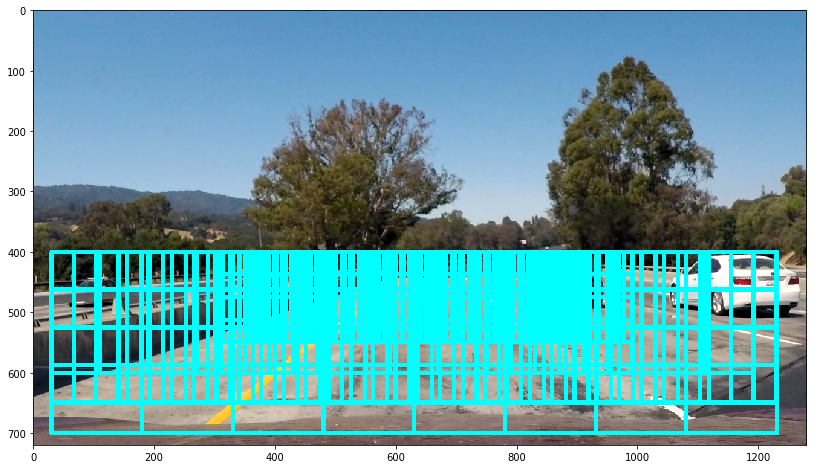

In [128]:
plt.figure(figsize=(14,8))
plt.imshow(windows)

In [129]:
hot_windows = search_windows(p_images[0], windows_final, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

out_img = draw_boxes(image, hot_windows, color=(255, 0, 255), thick=3)

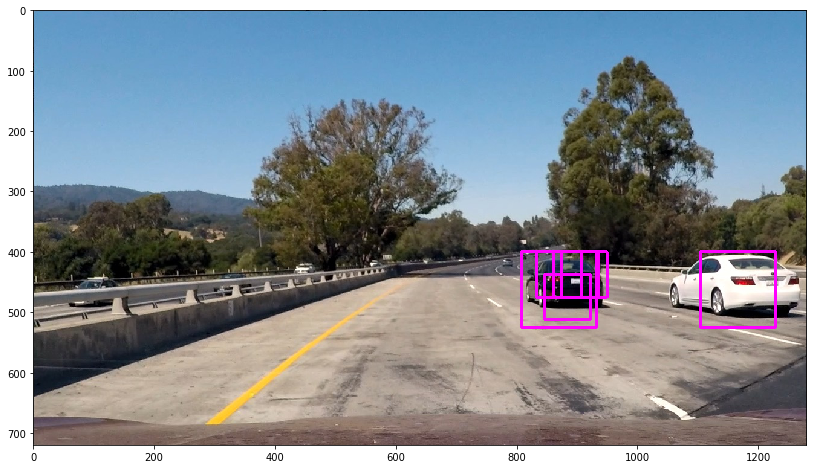

In [130]:
plt.figure(figsize=(14,8))
plt.imshow(out_img)

In [107]:
from collections import deque
class VehicleTracking:
    def __init__(self):
        self.labels_queue = deque()
        self.nlabels = 25
        self.boxes_queue = deque()
        self.nboxes_lists = 40
    def __filter_non_continuous(self, labels):
        label_mesh, label_count = labels
        label_mesh = label_mesh.astype(np.uint8)

        new_mesh = np.zeros_like(label_mesh, dtype=np.uint8)
        for label in range(1, label_count + 1):
            tmp_mesh = np.zeros_like(label_mesh, dtype=np.uint8)
            # regardless of label start with 1
            tmp_mesh[label_mesh == label] = 1
            for prev_lab in self.labels_queue:
                # reset all values to one and start adding
                prev_lab[prev_lab > 0] = 1
                tmp_mesh += prev_lab
            #print('tmp mesh looks like')
            #print(np.max(tmp_mesh))
            #print(np.min(tmp_mesh))
            #print(np.mean(tmp_mesh))
            if np.max(tmp_mesh) > self.nlabels:
                new_mesh[label_mesh == label] = np.max(new_mesh) + 1
        return new_mesh, np.max(new_mesh)

    def remove_false_positives(self, shape, raw_boxes):
        heatmap = np.zeros(shape, dtype=np.float)
        #print(heatmap.shape)
        if len(self.boxes_queue) < self.nboxes_lists:
            self.boxes_queue.append(raw_boxes)
            #print('not enough boxes history ' + str(len(self.boxes_queue)))
            return [], heatmap

        #print('removing false positives')
        self.boxes_queue.popleft()
        self.boxes_queue.append(raw_boxes)

        for boxlist in self.boxes_queue:
            heatmap = add_heat(heatmap, boxlist)

        heatmap = apply_threshold(heatmap, threshold = 40)
        labels = label(heatmap)

        #print(labels[0].shape)
        #print(np.max(labels[0]))
        #print(np.mean(labels[0]))
        #print(np.median(labels[0]))

        self.labels_queue.append(labels[0].astype(np.uint8))
        if len(self.labels_queue) > self.nlabels:
            self.labels_queue.popleft()
        labels = self.__filter_non_continuous(labels)

        if labels[1] > 0:
            print('ended with ' + str(labels[1]) + ' cars')
        return labels, heatmap

In [108]:
# Vehicle Tracking is worked to select rectangle.
vt = VehicleTracking()

In [109]:
## import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [110]:
hot_windows_list = []

video_output = 'output_images/project_video_sliding_found3.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(pipeline2) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_sliding_found3.mp4
[MoviePy] Writing video output_images/project_video_sliding_found3.mp4



 12%|█▏        | 152/1261 [03:22<24:36,  1.33s/it]


 17%|█▋        | 220/1261 [04:39<22:02,  1.27s/it]

ended with 1 cars



 18%|█▊        | 221/1261 [04:40<22:00,  1.27s/it]

ended with 1 cars



 18%|█▊        | 222/1261 [04:41<21:58,  1.27s/it]

ended with 1 cars



 18%|█▊        | 223/1261 [04:42<21:57,  1.27s/it]

ended with 1 cars



 18%|█▊        | 224/1261 [04:44<21:55,  1.27s/it]

ended with 1 cars



 18%|█▊        | 225/1261 [04:45<21:53,  1.27s/it]

ended with 1 cars



 18%|█▊        | 226/1261 [04:46<21:51,  1.27s/it]

ended with 1 cars



 18%|█▊        | 227/1261 [04:47<21:49,  1.27s/it]

ended with 1 cars



 18%|█▊        | 228/1261 [04:48<21:48,  1.27s/it]

ended with 1 cars



 18%|█▊        | 229/1261 [04:49<21:46,  1.27s/it]

ended with 1 cars



 18%|█▊        | 230/1261 [04:51<21:44,  1.27s/it]

ended with 1 cars



 18%|█▊        | 231/1261 [04:52<21:42,  1.26s/it]

ended with 1 cars



 18%|█▊        | 232/1261 [04:53<21:40,  1.26s/it]

ended with 1 cars



 18%|█▊        | 233/1261 [04:54<21:39,  1.26s/it]

ended with 1 cars



 19%|█▊        | 234/1261 [04:55<21:37,  1.26s/it]

ended with 1 cars



 19%|█▊        | 235/1261 [04:56<21:35,  1.26s/it]

ended with 1 cars



 19%|█▊        | 236/1261 [04:57<21:33,  1.26s/it]

ended with 1 cars



 19%|█▉        | 237/1261 [04:59<21:32,  1.26s/it]

ended with 1 cars



 19%|█▉        | 238/1261 [05:00<21:30,  1.26s/it]

ended with 1 cars



 19%|█▉        | 239/1261 [05:01<21:28,  1.26s/it]

ended with 1 cars



 19%|█▉        | 240/1261 [05:02<21:26,  1.26s/it]

ended with 1 cars



 19%|█▉        | 241/1261 [05:03<21:25,  1.26s/it]

ended with 1 cars



 19%|█▉        | 242/1261 [05:04<21:23,  1.26s/it]

ended with 1 cars



 19%|█▉        | 243/1261 [05:05<21:21,  1.26s/it]

ended with 1 cars



 19%|█▉        | 244/1261 [05:07<21:20,  1.26s/it]

ended with 1 cars



 19%|█▉        | 245/1261 [05:08<21:18,  1.26s/it]

ended with 1 cars



 20%|█▉        | 246/1261 [05:09<21:16,  1.26s/it]

ended with 1 cars



 20%|█▉        | 247/1261 [05:10<21:15,  1.26s/it]

ended with 1 cars



 20%|█▉        | 248/1261 [05:11<21:13,  1.26s/it]

ended with 1 cars



 20%|█▉        | 249/1261 [05:12<21:11,  1.26s/it]

ended with 1 cars



 20%|█▉        | 250/1261 [05:14<21:10,  1.26s/it]

ended with 1 cars



 20%|█▉        | 251/1261 [05:15<21:08,  1.26s/it]

ended with 1 cars



 20%|█▉        | 252/1261 [05:16<21:06,  1.26s/it]

ended with 1 cars



 20%|██        | 253/1261 [05:17<21:04,  1.25s/it]

ended with 1 cars



 20%|██        | 254/1261 [05:18<21:03,  1.25s/it]

ended with 1 cars



 20%|██        | 255/1261 [05:19<21:01,  1.25s/it]

ended with 1 cars



 20%|██        | 256/1261 [05:20<20:59,  1.25s/it]

ended with 1 cars



 20%|██        | 257/1261 [05:22<20:58,  1.25s/it]

ended with 1 cars



 20%|██        | 258/1261 [05:23<20:56,  1.25s/it]

ended with 1 cars



 21%|██        | 259/1261 [05:24<20:54,  1.25s/it]

ended with 1 cars



 21%|██        | 260/1261 [05:25<20:53,  1.25s/it]

ended with 1 cars



 21%|██        | 261/1261 [05:26<20:51,  1.25s/it]

ended with 1 cars



 21%|██        | 262/1261 [05:27<20:50,  1.25s/it]

ended with 1 cars



 21%|██        | 263/1261 [05:28<20:48,  1.25s/it]

ended with 1 cars



 21%|██        | 264/1261 [05:30<20:46,  1.25s/it]

ended with 1 cars



 21%|██        | 265/1261 [05:31<20:45,  1.25s/it]

ended with 1 cars



 21%|██        | 266/1261 [05:32<20:43,  1.25s/it]

ended with 1 cars



 21%|██        | 267/1261 [05:33<20:41,  1.25s/it]

ended with 1 cars



 21%|██▏       | 268/1261 [05:34<20:40,  1.25s/it]

ended with 1 cars



 21%|██▏       | 269/1261 [05:35<20:38,  1.25s/it]

ended with 1 cars



 21%|██▏       | 270/1261 [05:37<20:37,  1.25s/it]

ended with 1 cars



 21%|██▏       | 271/1261 [05:38<20:35,  1.25s/it]

ended with 1 cars



 22%|██▏       | 272/1261 [05:39<20:34,  1.25s/it]

ended with 1 cars



 22%|██▏       | 273/1261 [05:40<20:34,  1.25s/it]

ended with 1 cars



 22%|██▏       | 274/1261 [05:42<20:32,  1.25s/it]

ended with 1 cars



 22%|██▏       | 275/1261 [05:44<20:34,  1.25s/it]

ended with 1 cars



 22%|██▏       | 276/1261 [05:45<20:33,  1.25s/it]

ended with 1 cars



 22%|██▏       | 277/1261 [05:46<20:31,  1.25s/it]

ended with 1 cars



 22%|██▏       | 278/1261 [05:48<20:31,  1.25s/it]

ended with 1 cars



 22%|██▏       | 279/1261 [05:50<20:33,  1.26s/it]

ended with 1 cars



 22%|██▏       | 280/1261 [05:53<20:38,  1.26s/it]

ended with 1 cars



 22%|██▏       | 281/1261 [05:55<20:39,  1.27s/it]

ended with 1 cars



 22%|██▏       | 282/1261 [05:56<20:38,  1.27s/it]

ended with 1 cars



 22%|██▏       | 283/1261 [05:58<20:38,  1.27s/it]

ended with 1 cars



 23%|██▎       | 284/1261 [05:59<20:37,  1.27s/it]

ended with 1 cars



 23%|██▎       | 285/1261 [06:01<20:36,  1.27s/it]

ended with 1 cars



 23%|██▎       | 286/1261 [06:02<20:35,  1.27s/it]

ended with 1 cars



 23%|██▎       | 287/1261 [06:04<20:35,  1.27s/it]

ended with 1 cars



 23%|██▎       | 288/1261 [06:05<20:34,  1.27s/it]

ended with 1 cars



 23%|██▎       | 289/1261 [06:06<20:33,  1.27s/it]

ended with 1 cars



 23%|██▎       | 290/1261 [06:08<20:32,  1.27s/it]

ended with 1 cars



 23%|██▎       | 291/1261 [06:09<20:31,  1.27s/it]

ended with 1 cars



 23%|██▎       | 292/1261 [06:11<20:31,  1.27s/it]

ended with 1 cars



 23%|██▎       | 293/1261 [06:12<20:30,  1.27s/it]

ended with 1 cars



 23%|██▎       | 294/1261 [06:13<20:28,  1.27s/it]

ended with 1 cars



 23%|██▎       | 295/1261 [06:14<20:26,  1.27s/it]

ended with 1 cars



 23%|██▎       | 296/1261 [06:15<20:25,  1.27s/it]

ended with 1 cars



 24%|██▎       | 297/1261 [06:17<20:23,  1.27s/it]

ended with 1 cars



 24%|██▎       | 298/1261 [06:18<20:23,  1.27s/it]

ended with 1 cars



 24%|██▎       | 299/1261 [06:19<20:21,  1.27s/it]

ended with 1 cars



 24%|██▍       | 300/1261 [06:21<20:21,  1.27s/it]

ended with 1 cars



 24%|██▍       | 301/1261 [06:22<20:20,  1.27s/it]

ended with 1 cars



 24%|██▍       | 302/1261 [06:23<20:18,  1.27s/it]

ended with 1 cars



 24%|██▍       | 303/1261 [06:25<20:17,  1.27s/it]

ended with 1 cars



 24%|██▍       | 304/1261 [06:26<20:15,  1.27s/it]

ended with 1 cars



 24%|██▍       | 305/1261 [06:27<20:14,  1.27s/it]

ended with 1 cars



 24%|██▍       | 306/1261 [06:28<20:13,  1.27s/it]

ended with 1 cars



 24%|██▍       | 307/1261 [06:30<20:13,  1.27s/it]

ended with 1 cars



 24%|██▍       | 308/1261 [06:31<20:11,  1.27s/it]

ended with 1 cars



 25%|██▍       | 309/1261 [06:32<20:09,  1.27s/it]

ended with 1 cars



 25%|██▍       | 310/1261 [06:34<20:09,  1.27s/it]

ended with 1 cars



 25%|██▍       | 311/1261 [06:35<20:07,  1.27s/it]

ended with 1 cars



 25%|██▍       | 312/1261 [06:36<20:06,  1.27s/it]

ended with 1 cars



 25%|██▍       | 313/1261 [06:37<20:05,  1.27s/it]

ended with 1 cars



 25%|██▍       | 314/1261 [06:39<20:03,  1.27s/it]

ended with 1 cars



 25%|██▍       | 315/1261 [06:40<20:01,  1.27s/it]

ended with 1 cars



 25%|██▌       | 316/1261 [06:41<20:00,  1.27s/it]

ended with 1 cars



 25%|██▌       | 317/1261 [06:42<19:58,  1.27s/it]

ended with 1 cars



 25%|██▌       | 318/1261 [06:43<19:57,  1.27s/it]

ended with 1 cars



 25%|██▌       | 319/1261 [06:44<19:55,  1.27s/it]

ended with 1 cars



 25%|██▌       | 320/1261 [06:45<19:53,  1.27s/it]

ended with 1 cars



 25%|██▌       | 321/1261 [06:47<19:52,  1.27s/it]

ended with 1 cars



 26%|██▌       | 322/1261 [06:48<19:50,  1.27s/it]

ended with 1 cars



 26%|██▌       | 323/1261 [06:49<19:49,  1.27s/it]

ended with 1 cars



 26%|██▌       | 324/1261 [06:50<19:47,  1.27s/it]

ended with 1 cars



 26%|██▌       | 325/1261 [06:51<19:45,  1.27s/it]

ended with 1 cars



 26%|██▌       | 326/1261 [06:52<19:44,  1.27s/it]

ended with 1 cars



 26%|██▌       | 327/1261 [06:54<19:42,  1.27s/it]

ended with 1 cars



 26%|██▌       | 328/1261 [06:55<19:41,  1.27s/it]

ended with 1 cars



 26%|██▌       | 329/1261 [06:56<19:39,  1.27s/it]

ended with 1 cars



 26%|██▌       | 330/1261 [06:57<19:38,  1.27s/it]

ended with 1 cars



 26%|██▌       | 331/1261 [06:58<19:36,  1.27s/it]

ended with 1 cars



 26%|██▋       | 332/1261 [06:59<19:34,  1.26s/it]

ended with 1 cars



 26%|██▋       | 333/1261 [07:01<19:33,  1.26s/it]

ended with 1 cars



 26%|██▋       | 334/1261 [07:02<19:31,  1.26s/it]

ended with 1 cars



 27%|██▋       | 335/1261 [07:03<19:30,  1.26s/it]

ended with 1 cars



 27%|██▋       | 336/1261 [07:04<19:28,  1.26s/it]

ended with 1 cars



 27%|██▋       | 337/1261 [07:05<19:27,  1.26s/it]

ended with 1 cars



 27%|██▋       | 338/1261 [07:06<19:25,  1.26s/it]

ended with 1 cars



 27%|██▋       | 339/1261 [07:08<19:24,  1.26s/it]

ended with 1 cars



 27%|██▋       | 340/1261 [07:09<19:22,  1.26s/it]

ended with 1 cars



 27%|██▋       | 341/1261 [07:10<19:20,  1.26s/it]

ended with 1 cars



 27%|██▋       | 342/1261 [07:11<19:19,  1.26s/it]

ended with 1 cars



 27%|██▋       | 343/1261 [07:12<19:17,  1.26s/it]

ended with 1 cars



 27%|██▋       | 344/1261 [07:13<19:16,  1.26s/it]

ended with 1 cars



 27%|██▋       | 345/1261 [07:15<19:15,  1.26s/it]

ended with 1 cars



 27%|██▋       | 346/1261 [07:16<19:13,  1.26s/it]

ended with 1 cars



 28%|██▊       | 347/1261 [07:17<19:12,  1.26s/it]

ended with 1 cars



 28%|██▊       | 348/1261 [07:18<19:10,  1.26s/it]

ended with 1 cars



 28%|██▊       | 349/1261 [07:19<19:08,  1.26s/it]

ended with 1 cars



 28%|██▊       | 350/1261 [07:20<19:07,  1.26s/it]

ended with 1 cars



 28%|██▊       | 351/1261 [07:21<19:05,  1.26s/it]

ended with 1 cars



 28%|██▊       | 352/1261 [07:23<19:04,  1.26s/it]

ended with 1 cars



 28%|██▊       | 353/1261 [07:24<19:02,  1.26s/it]

ended with 1 cars



 28%|██▊       | 354/1261 [07:25<19:01,  1.26s/it]

ended with 1 cars



 28%|██▊       | 355/1261 [07:26<18:59,  1.26s/it]

ended with 1 cars



 28%|██▊       | 356/1261 [07:27<18:58,  1.26s/it]

ended with 1 cars



 28%|██▊       | 357/1261 [07:28<18:56,  1.26s/it]

ended with 1 cars



 28%|██▊       | 358/1261 [07:30<18:55,  1.26s/it]

ended with 1 cars



 28%|██▊       | 359/1261 [07:31<18:53,  1.26s/it]

ended with 1 cars



 29%|██▊       | 360/1261 [07:32<18:52,  1.26s/it]

ended with 1 cars



 29%|██▊       | 361/1261 [07:33<18:50,  1.26s/it]

ended with 1 cars



 29%|██▊       | 362/1261 [07:34<18:49,  1.26s/it]

ended with 1 cars



 29%|██▉       | 363/1261 [07:35<18:47,  1.26s/it]

ended with 1 cars



 29%|██▉       | 364/1261 [07:36<18:45,  1.26s/it]

ended with 1 cars



 29%|██▉       | 365/1261 [07:38<18:44,  1.25s/it]

ended with 1 cars



 29%|██▉       | 366/1261 [07:39<18:42,  1.25s/it]

ended with 1 cars



 29%|██▉       | 367/1261 [07:40<18:41,  1.25s/it]

ended with 1 cars



 29%|██▉       | 368/1261 [07:41<18:39,  1.25s/it]

ended with 1 cars



 29%|██▉       | 369/1261 [07:42<18:38,  1.25s/it]

ended with 1 cars



 29%|██▉       | 370/1261 [07:43<18:36,  1.25s/it]

ended with 1 cars



 29%|██▉       | 371/1261 [07:44<18:35,  1.25s/it]

ended with 1 cars



 30%|██▉       | 372/1261 [07:46<18:33,  1.25s/it]

ended with 1 cars



 30%|██▉       | 373/1261 [07:47<18:32,  1.25s/it]

ended with 1 cars



 30%|██▉       | 374/1261 [07:48<18:30,  1.25s/it]

ended with 1 cars



 30%|██▉       | 375/1261 [07:49<18:29,  1.25s/it]

ended with 1 cars



 30%|██▉       | 376/1261 [07:50<18:28,  1.25s/it]

ended with 1 cars



 30%|██▉       | 377/1261 [07:51<18:26,  1.25s/it]

ended with 1 cars



 30%|██▉       | 378/1261 [07:53<18:25,  1.25s/it]

ended with 1 cars



 30%|███       | 379/1261 [07:54<18:23,  1.25s/it]

ended with 1 cars



 30%|███       | 380/1261 [07:55<18:22,  1.25s/it]

ended with 1 cars



 30%|███       | 381/1261 [07:56<18:20,  1.25s/it]

ended with 1 cars



 30%|███       | 382/1261 [07:57<18:19,  1.25s/it]

ended with 1 cars



 30%|███       | 383/1261 [07:58<18:17,  1.25s/it]

ended with 1 cars



 30%|███       | 384/1261 [08:00<18:16,  1.25s/it]

ended with 1 cars



 31%|███       | 385/1261 [08:01<18:14,  1.25s/it]

ended with 1 cars



 31%|███       | 386/1261 [08:02<18:13,  1.25s/it]

ended with 1 cars



 31%|███       | 387/1261 [08:03<18:12,  1.25s/it]

ended with 1 cars



 31%|███       | 388/1261 [08:04<18:10,  1.25s/it]

ended with 1 cars



 31%|███       | 389/1261 [08:05<18:09,  1.25s/it]

ended with 1 cars



 31%|███       | 390/1261 [08:06<18:07,  1.25s/it]

ended with 1 cars



 31%|███       | 391/1261 [08:08<18:06,  1.25s/it]

ended with 1 cars



 31%|███       | 392/1261 [08:09<18:04,  1.25s/it]

ended with 1 cars



 31%|███       | 393/1261 [08:10<18:03,  1.25s/it]

ended with 1 cars



 31%|███       | 394/1261 [08:11<18:01,  1.25s/it]

ended with 1 cars



 31%|███▏      | 395/1261 [08:12<18:00,  1.25s/it]

ended with 1 cars



 31%|███▏      | 396/1261 [08:13<17:58,  1.25s/it]

ended with 1 cars



 31%|███▏      | 397/1261 [08:15<17:57,  1.25s/it]

ended with 1 cars



 32%|███▏      | 398/1261 [08:16<17:55,  1.25s/it]

ended with 1 cars



 32%|███▏      | 399/1261 [08:17<17:54,  1.25s/it]

ended with 1 cars



 32%|███▏      | 400/1261 [08:18<17:52,  1.25s/it]

ended with 1 cars



 32%|███▏      | 401/1261 [08:19<17:51,  1.25s/it]

ended with 1 cars



 32%|███▏      | 402/1261 [08:20<17:50,  1.25s/it]

ended with 1 cars



 32%|███▏      | 403/1261 [08:21<17:48,  1.25s/it]

ended with 1 cars



 32%|███▏      | 404/1261 [08:23<17:47,  1.25s/it]

ended with 1 cars



 32%|███▏      | 405/1261 [08:24<17:45,  1.25s/it]

ended with 1 cars



 32%|███▏      | 406/1261 [08:25<17:44,  1.24s/it]

ended with 1 cars



 32%|███▏      | 407/1261 [08:26<17:42,  1.24s/it]

ended with 1 cars



 32%|███▏      | 408/1261 [08:27<17:41,  1.24s/it]

ended with 1 cars



 32%|███▏      | 409/1261 [08:28<17:39,  1.24s/it]

ended with 1 cars



 33%|███▎      | 410/1261 [08:30<17:38,  1.24s/it]

ended with 1 cars



 33%|███▎      | 411/1261 [08:31<17:37,  1.24s/it]

ended with 1 cars



 33%|███▎      | 412/1261 [08:32<17:35,  1.24s/it]

ended with 1 cars



 33%|███▎      | 413/1261 [08:33<17:34,  1.24s/it]

ended with 1 cars



 33%|███▎      | 414/1261 [08:34<17:33,  1.24s/it]

ended with 1 cars



 33%|███▎      | 415/1261 [08:36<17:32,  1.24s/it]

ended with 1 cars



 33%|███▎      | 416/1261 [08:37<17:31,  1.24s/it]

ended with 1 cars



 33%|███▎      | 417/1261 [08:38<17:29,  1.24s/it]

ended with 1 cars



 33%|███▎      | 418/1261 [08:39<17:28,  1.24s/it]

ended with 1 cars



 33%|███▎      | 419/1261 [08:40<17:26,  1.24s/it]

ended with 1 cars



 33%|███▎      | 420/1261 [08:42<17:25,  1.24s/it]

ended with 1 cars



 33%|███▎      | 421/1261 [08:43<17:24,  1.24s/it]

ended with 1 cars



 33%|███▎      | 422/1261 [08:44<17:22,  1.24s/it]

ended with 1 cars



 34%|███▎      | 423/1261 [08:45<17:21,  1.24s/it]

ended with 1 cars



 34%|███▎      | 424/1261 [08:46<17:19,  1.24s/it]

ended with 1 cars



 34%|███▎      | 425/1261 [08:47<17:18,  1.24s/it]

ended with 1 cars



 34%|███▍      | 426/1261 [08:49<17:17,  1.24s/it]

ended with 1 cars



 34%|███▍      | 427/1261 [08:50<17:15,  1.24s/it]

ended with 1 cars



 34%|███▍      | 428/1261 [08:51<17:14,  1.24s/it]

ended with 1 cars



 34%|███▍      | 429/1261 [08:52<17:12,  1.24s/it]

ended with 1 cars



 34%|███▍      | 430/1261 [08:53<17:11,  1.24s/it]

ended with 1 cars



 34%|███▍      | 431/1261 [08:54<17:09,  1.24s/it]

ended with 1 cars



 34%|███▍      | 432/1261 [08:55<17:08,  1.24s/it]

ended with 1 cars



 34%|███▍      | 433/1261 [08:57<17:07,  1.24s/it]

ended with 1 cars



 34%|███▍      | 434/1261 [08:58<17:05,  1.24s/it]

ended with 1 cars



 34%|███▍      | 435/1261 [08:59<17:04,  1.24s/it]

ended with 1 cars



 35%|███▍      | 436/1261 [09:00<17:02,  1.24s/it]

ended with 1 cars



 35%|███▍      | 437/1261 [09:01<17:01,  1.24s/it]

ended with 1 cars



 35%|███▍      | 438/1261 [09:02<16:59,  1.24s/it]

ended with 1 cars



 35%|███▍      | 439/1261 [09:03<16:58,  1.24s/it]

ended with 1 cars



 35%|███▍      | 440/1261 [09:05<16:57,  1.24s/it]

ended with 1 cars



 35%|███▍      | 441/1261 [09:06<16:55,  1.24s/it]

ended with 1 cars



 35%|███▌      | 442/1261 [09:07<16:54,  1.24s/it]

ended with 1 cars



 35%|███▌      | 443/1261 [09:08<16:52,  1.24s/it]

ended with 1 cars



 35%|███▌      | 444/1261 [09:09<16:51,  1.24s/it]

ended with 1 cars



 35%|███▌      | 445/1261 [09:10<16:49,  1.24s/it]

ended with 1 cars



 35%|███▌      | 446/1261 [09:11<16:48,  1.24s/it]

ended with 1 cars



 35%|███▌      | 447/1261 [09:13<16:47,  1.24s/it]

ended with 1 cars



 36%|███▌      | 448/1261 [09:14<16:45,  1.24s/it]

ended with 1 cars



 36%|███▌      | 449/1261 [09:15<16:44,  1.24s/it]

ended with 1 cars



 36%|███▌      | 450/1261 [09:16<16:42,  1.24s/it]

ended with 1 cars



 36%|███▌      | 451/1261 [09:17<16:41,  1.24s/it]

ended with 1 cars



 36%|███▌      | 452/1261 [09:18<16:40,  1.24s/it]

ended with 1 cars



 36%|███▌      | 453/1261 [09:19<16:38,  1.24s/it]

ended with 1 cars



 36%|███▌      | 454/1261 [09:21<16:37,  1.24s/it]

ended with 1 cars



 36%|███▌      | 455/1261 [09:22<16:36,  1.24s/it]

ended with 1 cars



 36%|███▌      | 456/1261 [09:23<16:34,  1.24s/it]

ended with 1 cars



 36%|███▌      | 457/1261 [09:24<16:33,  1.24s/it]

ended with 1 cars



 36%|███▋      | 458/1261 [09:25<16:31,  1.24s/it]

ended with 1 cars



 36%|███▋      | 459/1261 [09:26<16:30,  1.23s/it]

ended with 1 cars



 36%|███▋      | 460/1261 [09:27<16:29,  1.23s/it]

ended with 1 cars



 37%|███▋      | 461/1261 [09:29<16:27,  1.23s/it]

ended with 1 cars



 37%|███▋      | 462/1261 [09:30<16:26,  1.23s/it]

ended with 1 cars



 37%|███▋      | 463/1261 [09:31<16:24,  1.23s/it]

ended with 1 cars



 37%|███▋      | 464/1261 [09:32<16:23,  1.23s/it]

ended with 1 cars



 37%|███▋      | 465/1261 [09:33<16:22,  1.23s/it]

ended with 1 cars



 37%|███▋      | 466/1261 [09:34<16:20,  1.23s/it]

ended with 1 cars



 37%|███▋      | 467/1261 [09:36<16:19,  1.23s/it]

ended with 1 cars



 37%|███▋      | 468/1261 [09:37<16:17,  1.23s/it]

ended with 1 cars



 37%|███▋      | 469/1261 [09:38<16:16,  1.23s/it]

ended with 1 cars



 37%|███▋      | 470/1261 [09:39<16:15,  1.23s/it]

ended with 1 cars



 37%|███▋      | 471/1261 [09:40<16:13,  1.23s/it]

ended with 1 cars



 37%|███▋      | 472/1261 [09:41<16:12,  1.23s/it]

ended with 1 cars



 38%|███▊      | 473/1261 [09:42<16:11,  1.23s/it]

ended with 1 cars



 38%|███▊      | 474/1261 [09:44<16:09,  1.23s/it]

ended with 1 cars



 38%|███▊      | 475/1261 [09:45<16:08,  1.23s/it]

ended with 1 cars



 38%|███▊      | 476/1261 [09:46<16:06,  1.23s/it]

ended with 1 cars



 38%|███▊      | 477/1261 [09:47<16:05,  1.23s/it]

ended with 1 cars



 38%|███▊      | 478/1261 [09:48<16:04,  1.23s/it]

ended with 1 cars



 38%|███▊      | 479/1261 [09:49<16:02,  1.23s/it]

ended with 1 cars



 38%|███▊      | 480/1261 [09:50<16:01,  1.23s/it]

ended with 1 cars



 38%|███▊      | 481/1261 [09:52<16:00,  1.23s/it]

ended with 1 cars



 38%|███▊      | 482/1261 [09:53<15:58,  1.23s/it]

ended with 1 cars



 38%|███▊      | 483/1261 [09:54<15:57,  1.23s/it]

ended with 1 cars



 38%|███▊      | 484/1261 [09:55<15:56,  1.23s/it]

ended with 1 cars



 38%|███▊      | 485/1261 [09:56<15:54,  1.23s/it]

ended with 1 cars



 39%|███▊      | 486/1261 [09:57<15:53,  1.23s/it]

ended with 1 cars



 39%|███▊      | 487/1261 [09:58<15:51,  1.23s/it]

ended with 1 cars



 39%|███▊      | 488/1261 [10:00<15:50,  1.23s/it]

ended with 1 cars



 39%|███▉      | 489/1261 [10:01<15:49,  1.23s/it]

ended with 1 cars



 39%|███▉      | 490/1261 [10:02<15:47,  1.23s/it]

ended with 1 cars



 39%|███▉      | 491/1261 [10:03<15:46,  1.23s/it]

ended with 1 cars



 39%|███▉      | 492/1261 [10:04<15:45,  1.23s/it]

ended with 1 cars



 39%|███▉      | 493/1261 [10:05<15:43,  1.23s/it]

ended with 1 cars



 39%|███▉      | 494/1261 [10:06<15:42,  1.23s/it]

ended with 1 cars



 39%|███▉      | 495/1261 [10:08<15:41,  1.23s/it]

ended with 1 cars



 39%|███▉      | 496/1261 [10:09<15:39,  1.23s/it]

ended with 1 cars



 39%|███▉      | 497/1261 [10:10<15:38,  1.23s/it]

ended with 1 cars



 39%|███▉      | 498/1261 [10:11<15:37,  1.23s/it]

ended with 1 cars



 40%|███▉      | 499/1261 [10:13<15:36,  1.23s/it]

ended with 1 cars



 40%|███▉      | 500/1261 [10:14<15:35,  1.23s/it]

ended with 1 cars



 40%|███▉      | 501/1261 [10:15<15:33,  1.23s/it]

ended with 1 cars



 40%|███▉      | 502/1261 [10:16<15:32,  1.23s/it]

ended with 1 cars



 40%|███▉      | 503/1261 [10:18<15:31,  1.23s/it]

ended with 1 cars



 40%|███▉      | 504/1261 [10:19<15:30,  1.23s/it]

ended with 1 cars



 40%|████      | 505/1261 [10:20<15:28,  1.23s/it]

ended with 1 cars



 40%|████      | 506/1261 [10:21<15:27,  1.23s/it]

ended with 1 cars



 40%|████      | 507/1261 [10:22<15:26,  1.23s/it]

ended with 1 cars



 40%|████      | 508/1261 [10:23<15:24,  1.23s/it]

ended with 1 cars



 40%|████      | 509/1261 [10:25<15:23,  1.23s/it]

ended with 1 cars



 40%|████      | 510/1261 [10:26<15:22,  1.23s/it]

ended with 1 cars



 41%|████      | 511/1261 [10:27<15:20,  1.23s/it]

ended with 1 cars



 41%|████      | 512/1261 [10:28<15:19,  1.23s/it]

ended with 1 cars



 41%|████      | 513/1261 [10:29<15:18,  1.23s/it]

ended with 1 cars



 41%|████      | 514/1261 [10:30<15:16,  1.23s/it]

ended with 1 cars



 41%|████      | 515/1261 [10:31<15:15,  1.23s/it]

ended with 1 cars



 41%|████      | 516/1261 [10:33<15:14,  1.23s/it]

ended with 1 cars



 41%|████      | 517/1261 [10:34<15:13,  1.23s/it]

ended with 1 cars



 41%|████      | 518/1261 [10:35<15:11,  1.23s/it]

ended with 1 cars



 41%|████      | 519/1261 [10:36<15:10,  1.23s/it]

ended with 1 cars



 41%|████      | 520/1261 [10:37<15:09,  1.23s/it]

ended with 1 cars



 41%|████▏     | 521/1261 [10:39<15:07,  1.23s/it]

ended with 1 cars



 41%|████▏     | 522/1261 [10:40<15:06,  1.23s/it]

ended with 1 cars



 41%|████▏     | 523/1261 [10:41<15:05,  1.23s/it]

ended with 1 cars



 42%|████▏     | 524/1261 [10:42<15:03,  1.23s/it]

ended with 1 cars



 42%|████▏     | 525/1261 [10:43<15:02,  1.23s/it]

ended with 1 cars



 42%|████▏     | 526/1261 [10:44<15:01,  1.23s/it]

ended with 1 cars



 42%|████▏     | 527/1261 [10:46<14:59,  1.23s/it]

ended with 1 cars



 42%|████▏     | 528/1261 [10:47<14:58,  1.23s/it]

ended with 1 cars



 42%|████▏     | 529/1261 [10:48<14:57,  1.23s/it]

ended with 1 cars



 42%|████▏     | 530/1261 [10:49<14:55,  1.23s/it]

ended with 1 cars



 42%|████▏     | 531/1261 [10:50<14:54,  1.23s/it]

ended with 1 cars



 42%|████▏     | 532/1261 [10:51<14:53,  1.23s/it]

ended with 1 cars



 42%|████▏     | 533/1261 [10:52<14:51,  1.22s/it]

ended with 1 cars



 42%|████▏     | 534/1261 [10:54<14:50,  1.22s/it]

ended with 1 cars



 42%|████▏     | 535/1261 [10:55<14:49,  1.22s/it]

ended with 1 cars



 43%|████▎     | 536/1261 [10:56<14:47,  1.22s/it]

ended with 1 cars



 43%|████▎     | 537/1261 [10:57<14:46,  1.22s/it]

ended with 1 cars



 43%|████▎     | 538/1261 [10:58<14:45,  1.22s/it]

ended with 1 cars



 43%|████▎     | 539/1261 [10:59<14:43,  1.22s/it]

ended with 1 cars



 43%|████▎     | 540/1261 [11:00<14:42,  1.22s/it]

ended with 1 cars



 43%|████▎     | 541/1261 [11:02<14:41,  1.22s/it]

ended with 1 cars



 43%|████▎     | 542/1261 [11:03<14:39,  1.22s/it]

ended with 1 cars



 43%|████▎     | 543/1261 [11:04<14:38,  1.22s/it]

ended with 1 cars



 43%|████▎     | 544/1261 [11:05<14:37,  1.22s/it]

ended with 1 cars



 43%|████▎     | 545/1261 [11:06<14:35,  1.22s/it]

ended with 1 cars



 43%|████▎     | 546/1261 [11:07<14:34,  1.22s/it]

ended with 1 cars



 43%|████▎     | 547/1261 [11:08<14:33,  1.22s/it]

ended with 1 cars



 43%|████▎     | 548/1261 [11:10<14:31,  1.22s/it]

ended with 1 cars



 44%|████▎     | 549/1261 [11:11<14:30,  1.22s/it]

ended with 1 cars



 44%|████▎     | 550/1261 [11:12<14:29,  1.22s/it]

ended with 1 cars



 44%|████▎     | 551/1261 [11:13<14:27,  1.22s/it]

ended with 1 cars



 44%|████▍     | 552/1261 [11:14<14:26,  1.22s/it]

ended with 1 cars



 44%|████▍     | 553/1261 [11:15<14:25,  1.22s/it]

ended with 1 cars



 44%|████▍     | 554/1261 [11:16<14:23,  1.22s/it]

ended with 1 cars



 44%|████▍     | 555/1261 [11:18<14:22,  1.22s/it]

ended with 1 cars



 44%|████▍     | 556/1261 [11:19<14:21,  1.22s/it]

ended with 1 cars



 44%|████▍     | 557/1261 [11:20<14:20,  1.22s/it]

ended with 1 cars



 44%|████▍     | 558/1261 [11:21<14:18,  1.22s/it]

ended with 1 cars



 44%|████▍     | 559/1261 [11:22<14:17,  1.22s/it]

ended with 1 cars



 44%|████▍     | 560/1261 [11:24<14:16,  1.22s/it]

ended with 1 cars



 44%|████▍     | 561/1261 [11:25<14:15,  1.22s/it]

ended with 1 cars



 45%|████▍     | 562/1261 [11:26<14:14,  1.22s/it]

ended with 1 cars



 45%|████▍     | 563/1261 [11:27<14:12,  1.22s/it]

ended with 1 cars



 45%|████▍     | 564/1261 [11:29<14:11,  1.22s/it]

ended with 1 cars



 45%|████▍     | 565/1261 [11:30<14:10,  1.22s/it]

ended with 1 cars



 45%|████▍     | 566/1261 [11:31<14:08,  1.22s/it]

ended with 1 cars



 45%|████▍     | 567/1261 [11:32<14:07,  1.22s/it]

ended with 1 cars



 45%|████▌     | 568/1261 [11:33<14:06,  1.22s/it]

ended with 1 cars



 45%|████▌     | 569/1261 [11:35<14:05,  1.22s/it]

ended with 1 cars



 45%|████▌     | 570/1261 [11:36<14:04,  1.22s/it]

ended with 1 cars



 45%|████▌     | 571/1261 [11:37<14:03,  1.22s/it]

ended with 1 cars



 45%|████▌     | 572/1261 [11:38<14:01,  1.22s/it]

ended with 1 cars



 45%|████▌     | 573/1261 [11:40<14:00,  1.22s/it]

ended with 1 cars



 46%|████▌     | 574/1261 [11:41<13:59,  1.22s/it]

ended with 1 cars



 46%|████▌     | 575/1261 [11:42<13:58,  1.22s/it]

ended with 1 cars



 46%|████▌     | 576/1261 [11:43<13:57,  1.22s/it]

ended with 1 cars



 46%|████▌     | 577/1261 [11:45<13:56,  1.22s/it]

ended with 1 cars



 46%|████▌     | 578/1261 [11:46<13:54,  1.22s/it]

ended with 1 cars



 46%|████▌     | 579/1261 [11:47<13:53,  1.22s/it]

ended with 1 cars



 46%|████▌     | 580/1261 [11:49<13:52,  1.22s/it]

ended with 1 cars



 46%|████▌     | 581/1261 [11:50<13:51,  1.22s/it]

ended with 1 cars



 46%|████▌     | 582/1261 [11:51<13:50,  1.22s/it]

ended with 1 cars



 46%|████▌     | 583/1261 [11:52<13:49,  1.22s/it]

ended with 1 cars



 46%|████▋     | 584/1261 [11:54<13:47,  1.22s/it]

ended with 1 cars



 46%|████▋     | 585/1261 [11:55<13:46,  1.22s/it]

ended with 1 cars



 46%|████▋     | 586/1261 [11:56<13:45,  1.22s/it]

ended with 1 cars



 47%|████▋     | 587/1261 [11:57<13:44,  1.22s/it]

ended with 1 cars



 47%|████▋     | 588/1261 [11:59<13:43,  1.22s/it]

ended with 1 cars



 47%|████▋     | 589/1261 [12:00<13:42,  1.22s/it]

ended with 1 cars



 47%|████▋     | 590/1261 [12:02<13:41,  1.22s/it]

ended with 1 cars



 47%|████▋     | 591/1261 [12:03<13:40,  1.22s/it]

ended with 1 cars



 47%|████▋     | 592/1261 [12:04<13:38,  1.22s/it]

ended with 1 cars



 47%|████▋     | 593/1261 [12:05<13:37,  1.22s/it]

ended with 1 cars



 47%|████▋     | 594/1261 [12:07<13:36,  1.22s/it]

ended with 1 cars



 47%|████▋     | 595/1261 [12:08<13:35,  1.22s/it]

ended with 1 cars



 47%|████▋     | 596/1261 [12:09<13:34,  1.22s/it]

ended with 1 cars



 47%|████▋     | 597/1261 [12:10<13:32,  1.22s/it]

ended with 1 cars



 47%|████▋     | 598/1261 [12:12<13:31,  1.22s/it]

ended with 1 cars



 48%|████▊     | 599/1261 [12:13<13:30,  1.22s/it]

ended with 1 cars



 48%|████▊     | 600/1261 [12:14<13:29,  1.22s/it]

ended with 1 cars



 48%|████▊     | 601/1261 [12:15<13:27,  1.22s/it]

ended with 1 cars



 48%|████▊     | 602/1261 [12:16<13:26,  1.22s/it]

ended with 1 cars



 48%|████▊     | 603/1261 [12:18<13:25,  1.22s/it]

ended with 1 cars



 48%|████▊     | 604/1261 [12:19<13:24,  1.22s/it]

ended with 1 cars



 48%|████▊     | 605/1261 [12:20<13:22,  1.22s/it]

ended with 1 cars



 48%|████▊     | 606/1261 [12:21<13:21,  1.22s/it]

ended with 1 cars



 48%|████▊     | 607/1261 [12:22<13:20,  1.22s/it]

ended with 1 cars



 48%|████▊     | 608/1261 [12:23<13:18,  1.22s/it]

ended with 1 cars



 48%|████▊     | 609/1261 [12:25<13:17,  1.22s/it]

ended with 1 cars



 48%|████▊     | 610/1261 [12:26<13:16,  1.22s/it]

ended with 1 cars



 48%|████▊     | 611/1261 [12:27<13:15,  1.22s/it]

ended with 1 cars



 49%|████▊     | 612/1261 [12:28<13:13,  1.22s/it]

ended with 1 cars



 49%|████▊     | 613/1261 [12:29<13:12,  1.22s/it]

ended with 1 cars



 49%|████▊     | 614/1261 [12:30<13:11,  1.22s/it]

ended with 1 cars



 49%|████▉     | 615/1261 [12:32<13:09,  1.22s/it]

ended with 1 cars



 49%|████▉     | 616/1261 [12:33<13:08,  1.22s/it]

ended with 1 cars



 49%|████▉     | 617/1261 [12:34<13:07,  1.22s/it]

ended with 1 cars



 49%|████▉     | 618/1261 [12:35<13:06,  1.22s/it]

ended with 1 cars



 49%|████▉     | 619/1261 [12:36<13:05,  1.22s/it]

ended with 1 cars



 49%|████▉     | 620/1261 [12:38<13:03,  1.22s/it]

ended with 1 cars



 49%|████▉     | 621/1261 [12:39<13:02,  1.22s/it]

ended with 1 cars



 49%|████▉     | 622/1261 [12:40<13:01,  1.22s/it]

ended with 1 cars



 49%|████▉     | 623/1261 [12:41<12:59,  1.22s/it]

ended with 1 cars



 49%|████▉     | 624/1261 [12:42<12:58,  1.22s/it]

ended with 1 cars



 50%|████▉     | 625/1261 [12:43<12:57,  1.22s/it]

ended with 1 cars



 50%|████▉     | 626/1261 [12:45<12:56,  1.22s/it]

ended with 1 cars



 50%|████▉     | 627/1261 [12:46<12:54,  1.22s/it]

ended with 1 cars



 50%|████▉     | 628/1261 [12:47<12:53,  1.22s/it]

ended with 1 cars



 50%|████▉     | 629/1261 [12:48<12:52,  1.22s/it]

ended with 1 cars



 50%|████▉     | 630/1261 [12:49<12:50,  1.22s/it]

ended with 1 cars



 50%|█████     | 631/1261 [12:50<12:49,  1.22s/it]

ended with 1 cars



 50%|█████     | 632/1261 [12:52<12:48,  1.22s/it]

ended with 1 cars



 50%|█████     | 633/1261 [12:53<12:47,  1.22s/it]

ended with 1 cars



 50%|█████     | 634/1261 [12:54<12:45,  1.22s/it]

ended with 1 cars



 50%|█████     | 635/1261 [12:55<12:44,  1.22s/it]

ended with 1 cars



 50%|█████     | 636/1261 [12:57<12:43,  1.22s/it]

ended with 1 cars



 51%|█████     | 637/1261 [12:58<12:42,  1.22s/it]

ended with 1 cars



 51%|█████     | 638/1261 [12:59<12:41,  1.22s/it]

ended with 1 cars



 51%|█████     | 639/1261 [13:00<12:40,  1.22s/it]

ended with 1 cars



 51%|█████     | 640/1261 [13:02<12:38,  1.22s/it]

ended with 1 cars



 51%|█████     | 641/1261 [13:03<12:37,  1.22s/it]

ended with 1 cars



 51%|█████     | 642/1261 [13:04<12:36,  1.22s/it]

ended with 1 cars



 51%|█████     | 643/1261 [13:05<12:35,  1.22s/it]

ended with 1 cars



 51%|█████     | 644/1261 [13:06<12:33,  1.22s/it]

ended with 1 cars



 51%|█████     | 645/1261 [13:07<12:32,  1.22s/it]

ended with 1 cars



 51%|█████     | 646/1261 [13:09<12:31,  1.22s/it]

ended with 1 cars



 51%|█████▏    | 647/1261 [13:10<12:29,  1.22s/it]

ended with 1 cars



 51%|█████▏    | 648/1261 [13:11<12:28,  1.22s/it]

ended with 1 cars



 51%|█████▏    | 649/1261 [13:12<12:27,  1.22s/it]

ended with 1 cars



 52%|█████▏    | 650/1261 [13:13<12:25,  1.22s/it]

ended with 1 cars



 52%|█████▏    | 651/1261 [13:14<12:24,  1.22s/it]

ended with 1 cars



 52%|█████▏    | 652/1261 [13:15<12:23,  1.22s/it]

ended with 1 cars



 52%|█████▏    | 653/1261 [13:17<12:22,  1.22s/it]

ended with 1 cars



 52%|█████▏    | 654/1261 [13:18<12:20,  1.22s/it]

ended with 1 cars



 52%|█████▏    | 655/1261 [13:19<12:19,  1.22s/it]

ended with 1 cars



 52%|█████▏    | 656/1261 [13:20<12:18,  1.22s/it]

ended with 1 cars



 52%|█████▏    | 657/1261 [13:22<12:17,  1.22s/it]

ended with 1 cars



 52%|█████▏    | 658/1261 [13:23<12:16,  1.22s/it]

ended with 1 cars



 52%|█████▏    | 659/1261 [13:24<12:15,  1.22s/it]

ended with 1 cars



 52%|█████▏    | 660/1261 [13:25<12:13,  1.22s/it]

ended with 1 cars



 52%|█████▏    | 661/1261 [13:27<12:12,  1.22s/it]

ended with 1 cars



 52%|█████▏    | 662/1261 [13:28<12:11,  1.22s/it]

ended with 1 cars



 53%|█████▎    | 663/1261 [13:29<12:10,  1.22s/it]

ended with 1 cars



 53%|█████▎    | 664/1261 [13:30<12:09,  1.22s/it]

ended with 1 cars



 53%|█████▎    | 665/1261 [13:32<12:07,  1.22s/it]

ended with 1 cars



 53%|█████▎    | 666/1261 [13:33<12:06,  1.22s/it]

ended with 1 cars



 53%|█████▎    | 667/1261 [13:34<12:05,  1.22s/it]

ended with 1 cars



 53%|█████▎    | 668/1261 [13:35<12:04,  1.22s/it]

ended with 1 cars



 53%|█████▎    | 669/1261 [13:36<12:02,  1.22s/it]

ended with 1 cars



 53%|█████▎    | 670/1261 [13:38<12:01,  1.22s/it]

ended with 1 cars



 53%|█████▎    | 671/1261 [13:39<12:00,  1.22s/it]

ended with 1 cars



 53%|█████▎    | 672/1261 [13:40<11:59,  1.22s/it]

ended with 1 cars



 53%|█████▎    | 673/1261 [13:41<11:57,  1.22s/it]

ended with 1 cars



 53%|█████▎    | 674/1261 [13:42<11:56,  1.22s/it]

ended with 1 cars



 54%|█████▎    | 675/1261 [13:44<11:55,  1.22s/it]

ended with 1 cars



 54%|█████▎    | 676/1261 [13:45<11:54,  1.22s/it]

ended with 1 cars



 54%|█████▎    | 677/1261 [13:46<11:52,  1.22s/it]

ended with 1 cars



 54%|█████▍    | 678/1261 [13:47<11:51,  1.22s/it]

ended with 1 cars



 54%|█████▍    | 679/1261 [13:48<11:50,  1.22s/it]

ended with 1 cars



 54%|█████▍    | 680/1261 [13:49<11:49,  1.22s/it]

ended with 1 cars



 54%|█████▍    | 681/1261 [13:50<11:47,  1.22s/it]

ended with 1 cars



 54%|█████▍    | 682/1261 [13:52<11:46,  1.22s/it]

ended with 1 cars



 54%|█████▍    | 683/1261 [13:53<11:45,  1.22s/it]

ended with 1 cars



 54%|█████▍    | 684/1261 [13:54<11:43,  1.22s/it]

ended with 1 cars



 54%|█████▍    | 685/1261 [13:55<11:42,  1.22s/it]

ended with 1 cars



 54%|█████▍    | 686/1261 [13:56<11:41,  1.22s/it]

ended with 1 cars



 54%|█████▍    | 687/1261 [13:58<11:40,  1.22s/it]

ended with 1 cars



 55%|█████▍    | 688/1261 [13:59<11:39,  1.22s/it]

ended with 1 cars



 55%|█████▍    | 689/1261 [14:00<11:37,  1.22s/it]

ended with 1 cars



 55%|█████▍    | 690/1261 [14:01<11:36,  1.22s/it]

ended with 1 cars



 55%|█████▍    | 691/1261 [14:03<11:35,  1.22s/it]

ended with 1 cars



 55%|█████▍    | 692/1261 [14:04<11:34,  1.22s/it]

ended with 1 cars



 55%|█████▍    | 693/1261 [14:05<11:33,  1.22s/it]

ended with 1 cars



 55%|█████▌    | 694/1261 [14:06<11:31,  1.22s/it]

ended with 1 cars



 55%|█████▌    | 695/1261 [14:07<11:30,  1.22s/it]

ended with 1 cars



 55%|█████▌    | 696/1261 [14:08<11:29,  1.22s/it]

ended with 1 cars



 55%|█████▌    | 697/1261 [14:10<11:27,  1.22s/it]

ended with 1 cars



 55%|█████▌    | 698/1261 [14:11<11:26,  1.22s/it]

ended with 1 cars



 55%|█████▌    | 699/1261 [14:12<11:25,  1.22s/it]

ended with 1 cars



 56%|█████▌    | 700/1261 [14:13<11:24,  1.22s/it]

ended with 1 cars



 56%|█████▌    | 701/1261 [14:14<11:22,  1.22s/it]

ended with 1 cars



 56%|█████▌    | 702/1261 [14:15<11:21,  1.22s/it]

ended with 1 cars



 56%|█████▌    | 703/1261 [14:16<11:20,  1.22s/it]

ended with 1 cars



 56%|█████▌    | 704/1261 [14:18<11:18,  1.22s/it]

ended with 1 cars



 56%|█████▌    | 705/1261 [14:19<11:17,  1.22s/it]

ended with 2 cars



 56%|█████▌    | 706/1261 [14:20<11:16,  1.22s/it]

ended with 1 cars



 56%|█████▌    | 707/1261 [14:21<11:15,  1.22s/it]

ended with 1 cars



 56%|█████▌    | 708/1261 [14:22<11:13,  1.22s/it]

ended with 1 cars



 56%|█████▌    | 709/1261 [14:24<11:12,  1.22s/it]

ended with 1 cars



 56%|█████▋    | 710/1261 [14:25<11:11,  1.22s/it]

ended with 1 cars



 56%|█████▋    | 711/1261 [14:26<11:10,  1.22s/it]

ended with 1 cars



 56%|█████▋    | 712/1261 [14:27<11:09,  1.22s/it]

ended with 1 cars



 57%|█████▋    | 713/1261 [14:29<11:07,  1.22s/it]

ended with 1 cars



 57%|█████▋    | 714/1261 [14:30<11:06,  1.22s/it]

ended with 1 cars



 57%|█████▋    | 715/1261 [14:31<11:05,  1.22s/it]

ended with 1 cars



 57%|█████▋    | 716/1261 [14:32<11:04,  1.22s/it]

ended with 1 cars



 57%|█████▋    | 717/1261 [14:33<11:02,  1.22s/it]

ended with 1 cars



 57%|█████▋    | 718/1261 [14:35<11:01,  1.22s/it]

ended with 1 cars



 57%|█████▋    | 719/1261 [14:36<11:00,  1.22s/it]

ended with 1 cars



 57%|█████▋    | 720/1261 [14:37<10:59,  1.22s/it]

ended with 1 cars



 57%|█████▋    | 721/1261 [14:38<10:58,  1.22s/it]

ended with 1 cars



 57%|█████▋    | 722/1261 [14:39<10:56,  1.22s/it]

ended with 1 cars



 57%|█████▋    | 723/1261 [14:41<10:55,  1.22s/it]

ended with 1 cars



 57%|█████▋    | 724/1261 [14:42<10:54,  1.22s/it]

ended with 1 cars



 57%|█████▋    | 725/1261 [14:43<10:53,  1.22s/it]

ended with 1 cars



 58%|█████▊    | 726/1261 [14:44<10:51,  1.22s/it]

ended with 1 cars



 58%|█████▊    | 727/1261 [14:45<10:50,  1.22s/it]

ended with 1 cars



 58%|█████▊    | 728/1261 [14:46<10:49,  1.22s/it]

ended with 1 cars



 58%|█████▊    | 729/1261 [14:48<10:48,  1.22s/it]

ended with 1 cars



 58%|█████▊    | 730/1261 [14:49<10:46,  1.22s/it]

ended with 1 cars



 58%|█████▊    | 731/1261 [14:50<10:45,  1.22s/it]

ended with 1 cars



 58%|█████▊    | 732/1261 [14:51<10:44,  1.22s/it]

ended with 1 cars



 58%|█████▊    | 733/1261 [14:52<10:43,  1.22s/it]

ended with 1 cars



 58%|█████▊    | 734/1261 [14:53<10:41,  1.22s/it]

ended with 1 cars



 58%|█████▊    | 735/1261 [14:55<10:40,  1.22s/it]

ended with 1 cars



 58%|█████▊    | 736/1261 [14:56<10:39,  1.22s/it]

ended with 1 cars



 58%|█████▊    | 737/1261 [14:57<10:38,  1.22s/it]

ended with 1 cars



 59%|█████▊    | 738/1261 [14:58<10:36,  1.22s/it]

ended with 1 cars



 59%|█████▊    | 739/1261 [14:59<10:35,  1.22s/it]

ended with 1 cars



 59%|█████▊    | 740/1261 [15:00<10:34,  1.22s/it]

ended with 1 cars



 59%|█████▉    | 741/1261 [15:02<10:33,  1.22s/it]

ended with 1 cars



 59%|█████▉    | 742/1261 [15:03<10:31,  1.22s/it]

ended with 1 cars



 59%|█████▉    | 743/1261 [15:04<10:30,  1.22s/it]

ended with 1 cars



 59%|█████▉    | 744/1261 [15:05<10:29,  1.22s/it]

ended with 1 cars



 59%|█████▉    | 745/1261 [15:07<10:28,  1.22s/it]

ended with 2 cars



 59%|█████▉    | 746/1261 [15:08<10:27,  1.22s/it]

ended with 2 cars



 59%|█████▉    | 747/1261 [15:09<10:25,  1.22s/it]

ended with 2 cars



 59%|█████▉    | 748/1261 [15:10<10:24,  1.22s/it]

ended with 2 cars



 59%|█████▉    | 749/1261 [15:12<10:23,  1.22s/it]

ended with 2 cars



 59%|█████▉    | 750/1261 [15:13<10:22,  1.22s/it]

ended with 2 cars



 60%|█████▉    | 751/1261 [15:14<10:21,  1.22s/it]

ended with 2 cars



 60%|█████▉    | 752/1261 [15:15<10:19,  1.22s/it]

ended with 2 cars



 60%|█████▉    | 753/1261 [15:17<10:18,  1.22s/it]

ended with 2 cars



 60%|█████▉    | 754/1261 [15:18<10:17,  1.22s/it]

ended with 2 cars



 60%|█████▉    | 755/1261 [15:19<10:16,  1.22s/it]

ended with 2 cars



 60%|█████▉    | 756/1261 [15:20<10:14,  1.22s/it]

ended with 2 cars



 60%|██████    | 757/1261 [15:21<10:13,  1.22s/it]

ended with 2 cars



 60%|██████    | 758/1261 [15:22<10:12,  1.22s/it]

ended with 2 cars



 60%|██████    | 759/1261 [15:24<10:11,  1.22s/it]

ended with 2 cars



 60%|██████    | 760/1261 [15:25<10:10,  1.22s/it]

ended with 2 cars



 60%|██████    | 761/1261 [15:26<10:08,  1.22s/it]

ended with 2 cars



 60%|██████    | 762/1261 [15:28<10:07,  1.22s/it]

ended with 2 cars



 61%|██████    | 763/1261 [15:29<10:06,  1.22s/it]

ended with 2 cars



 61%|██████    | 764/1261 [15:30<10:05,  1.22s/it]

ended with 2 cars



 61%|██████    | 765/1261 [15:31<10:03,  1.22s/it]

ended with 2 cars



 61%|██████    | 766/1261 [15:32<10:02,  1.22s/it]

ended with 2 cars



 61%|██████    | 767/1261 [15:33<10:01,  1.22s/it]

ended with 2 cars



 61%|██████    | 768/1261 [15:35<10:00,  1.22s/it]

ended with 2 cars



 61%|██████    | 769/1261 [15:36<09:58,  1.22s/it]

ended with 2 cars



 61%|██████    | 770/1261 [15:37<09:57,  1.22s/it]

ended with 2 cars



 61%|██████    | 771/1261 [15:38<09:56,  1.22s/it]

ended with 2 cars



 61%|██████    | 772/1261 [15:39<09:55,  1.22s/it]

ended with 2 cars



 61%|██████▏   | 773/1261 [15:40<09:54,  1.22s/it]

ended with 2 cars



 61%|██████▏   | 774/1261 [15:42<09:52,  1.22s/it]

ended with 2 cars



 61%|██████▏   | 775/1261 [15:43<09:51,  1.22s/it]

ended with 2 cars



 62%|██████▏   | 776/1261 [15:44<09:50,  1.22s/it]

ended with 2 cars



 62%|██████▏   | 777/1261 [15:45<09:49,  1.22s/it]

ended with 2 cars



 62%|██████▏   | 778/1261 [15:46<09:47,  1.22s/it]

ended with 2 cars



 62%|██████▏   | 779/1261 [15:47<09:46,  1.22s/it]

ended with 2 cars



 62%|██████▏   | 780/1261 [15:49<09:45,  1.22s/it]

ended with 2 cars



 62%|██████▏   | 781/1261 [15:50<09:44,  1.22s/it]

ended with 1 cars



 62%|██████▏   | 782/1261 [15:51<09:42,  1.22s/it]

ended with 1 cars



 62%|██████▏   | 783/1261 [15:52<09:41,  1.22s/it]

ended with 1 cars



 62%|██████▏   | 784/1261 [15:53<09:40,  1.22s/it]

ended with 1 cars



 62%|██████▏   | 785/1261 [15:54<09:39,  1.22s/it]

ended with 1 cars



 62%|██████▏   | 786/1261 [15:56<09:37,  1.22s/it]

ended with 1 cars



 62%|██████▏   | 787/1261 [15:57<09:36,  1.22s/it]

ended with 1 cars



 62%|██████▏   | 788/1261 [15:58<09:35,  1.22s/it]

ended with 1 cars



 63%|██████▎   | 789/1261 [15:59<09:34,  1.22s/it]

ended with 1 cars



 63%|██████▎   | 790/1261 [16:00<09:32,  1.22s/it]

ended with 1 cars



 63%|██████▎   | 791/1261 [16:01<09:31,  1.22s/it]

ended with 1 cars



 63%|██████▎   | 792/1261 [16:03<09:30,  1.22s/it]

ended with 1 cars



 63%|██████▎   | 793/1261 [16:04<09:29,  1.22s/it]

ended with 1 cars



 63%|██████▎   | 794/1261 [16:05<09:27,  1.22s/it]

ended with 1 cars



 63%|██████▎   | 795/1261 [16:06<09:26,  1.22s/it]

ended with 1 cars



 63%|██████▎   | 796/1261 [16:07<09:25,  1.22s/it]

ended with 1 cars



 63%|██████▎   | 797/1261 [16:08<09:24,  1.22s/it]

ended with 1 cars



 63%|██████▎   | 798/1261 [16:10<09:22,  1.22s/it]

ended with 1 cars



 63%|██████▎   | 799/1261 [16:11<09:21,  1.22s/it]

ended with 1 cars



 63%|██████▎   | 800/1261 [16:12<09:20,  1.22s/it]

ended with 1 cars



 64%|██████▎   | 801/1261 [16:13<09:19,  1.22s/it]

ended with 1 cars



 64%|██████▎   | 802/1261 [16:14<09:17,  1.22s/it]

ended with 1 cars



 64%|██████▎   | 803/1261 [16:15<09:16,  1.22s/it]

ended with 1 cars



 64%|██████▍   | 804/1261 [16:17<09:15,  1.22s/it]

ended with 1 cars



 64%|██████▍   | 805/1261 [16:18<09:14,  1.22s/it]

ended with 1 cars



 64%|██████▍   | 806/1261 [16:19<09:12,  1.22s/it]

ended with 1 cars



 64%|██████▍   | 807/1261 [16:20<09:11,  1.22s/it]

ended with 1 cars



 64%|██████▍   | 808/1261 [16:21<09:10,  1.21s/it]

ended with 1 cars



 64%|██████▍   | 809/1261 [16:22<09:09,  1.21s/it]

ended with 1 cars



 64%|██████▍   | 810/1261 [16:24<09:07,  1.21s/it]

ended with 1 cars



 64%|██████▍   | 811/1261 [16:25<09:06,  1.21s/it]

ended with 1 cars



 64%|██████▍   | 812/1261 [16:26<09:05,  1.21s/it]

ended with 1 cars



 64%|██████▍   | 813/1261 [16:27<09:04,  1.21s/it]

ended with 1 cars



 65%|██████▍   | 814/1261 [16:28<09:02,  1.21s/it]

ended with 1 cars



 65%|██████▍   | 815/1261 [16:29<09:01,  1.21s/it]

ended with 1 cars



 65%|██████▍   | 816/1261 [16:30<09:00,  1.21s/it]

ended with 1 cars



 65%|██████▍   | 817/1261 [16:32<08:59,  1.21s/it]

ended with 1 cars



 65%|██████▍   | 818/1261 [16:33<08:57,  1.21s/it]

ended with 1 cars



 65%|██████▍   | 819/1261 [16:34<08:56,  1.21s/it]

ended with 1 cars



 65%|██████▌   | 820/1261 [16:36<08:55,  1.21s/it]

ended with 1 cars



 65%|██████▌   | 821/1261 [16:37<08:54,  1.21s/it]

ended with 1 cars



 65%|██████▌   | 822/1261 [16:38<08:53,  1.21s/it]

ended with 1 cars



 65%|██████▌   | 823/1261 [16:39<08:52,  1.21s/it]

ended with 2 cars



 65%|██████▌   | 824/1261 [16:41<08:50,  1.21s/it]

ended with 1 cars



 65%|██████▌   | 825/1261 [16:42<08:49,  1.21s/it]

ended with 2 cars



 66%|██████▌   | 826/1261 [16:43<08:48,  1.21s/it]

ended with 2 cars



 66%|██████▌   | 827/1261 [16:44<08:47,  1.21s/it]

ended with 2 cars



 66%|██████▌   | 828/1261 [16:45<08:45,  1.21s/it]

ended with 2 cars



 66%|██████▌   | 829/1261 [16:46<08:44,  1.21s/it]

ended with 2 cars



 66%|██████▌   | 830/1261 [16:48<08:43,  1.21s/it]

ended with 2 cars



 66%|██████▌   | 831/1261 [16:49<08:42,  1.21s/it]

ended with 2 cars



 66%|██████▌   | 832/1261 [16:50<08:40,  1.21s/it]

ended with 2 cars



 66%|██████▌   | 833/1261 [16:51<08:39,  1.21s/it]

ended with 2 cars



 66%|██████▌   | 834/1261 [16:52<08:38,  1.21s/it]

ended with 2 cars



 66%|██████▌   | 835/1261 [16:53<08:37,  1.21s/it]

ended with 2 cars



 66%|██████▋   | 836/1261 [16:55<08:36,  1.21s/it]

ended with 2 cars



 66%|██████▋   | 837/1261 [16:56<08:34,  1.21s/it]

ended with 2 cars



 66%|██████▋   | 838/1261 [16:57<08:33,  1.21s/it]

ended with 1 cars



 67%|██████▋   | 839/1261 [16:58<08:32,  1.21s/it]

ended with 1 cars



 67%|██████▋   | 840/1261 [16:59<08:31,  1.21s/it]

ended with 1 cars



 67%|██████▋   | 841/1261 [17:00<08:29,  1.21s/it]

ended with 1 cars



 67%|██████▋   | 842/1261 [17:02<08:28,  1.21s/it]

ended with 1 cars



 67%|██████▋   | 843/1261 [17:03<08:27,  1.21s/it]

ended with 1 cars



 67%|██████▋   | 844/1261 [17:04<08:26,  1.21s/it]

ended with 1 cars



 67%|██████▋   | 845/1261 [17:05<08:25,  1.21s/it]

ended with 1 cars



 67%|██████▋   | 846/1261 [17:07<08:23,  1.21s/it]

ended with 1 cars



 67%|██████▋   | 847/1261 [17:08<08:22,  1.21s/it]

ended with 1 cars



 67%|██████▋   | 848/1261 [17:09<08:21,  1.21s/it]

ended with 1 cars



 67%|██████▋   | 849/1261 [17:10<08:20,  1.21s/it]

ended with 1 cars



 67%|██████▋   | 850/1261 [17:11<08:18,  1.21s/it]

ended with 1 cars



 67%|██████▋   | 851/1261 [17:13<08:17,  1.21s/it]

ended with 1 cars



 68%|██████▊   | 852/1261 [17:14<08:16,  1.21s/it]

ended with 1 cars



 68%|██████▊   | 853/1261 [17:15<08:15,  1.21s/it]

ended with 1 cars



 68%|██████▊   | 854/1261 [17:16<08:14,  1.21s/it]

ended with 1 cars



 68%|██████▊   | 855/1261 [17:17<08:12,  1.21s/it]

ended with 1 cars



 68%|██████▊   | 856/1261 [17:18<08:11,  1.21s/it]

ended with 1 cars



 68%|██████▊   | 857/1261 [17:20<08:10,  1.21s/it]

ended with 1 cars



 68%|██████▊   | 858/1261 [17:21<08:09,  1.21s/it]

ended with 1 cars



 68%|██████▊   | 859/1261 [17:22<08:07,  1.21s/it]

ended with 1 cars



 68%|██████▊   | 860/1261 [17:23<08:06,  1.21s/it]

ended with 1 cars



 68%|██████▊   | 861/1261 [17:24<08:05,  1.21s/it]

ended with 1 cars



 68%|██████▊   | 862/1261 [17:25<08:04,  1.21s/it]

ended with 1 cars



 68%|██████▊   | 863/1261 [17:27<08:02,  1.21s/it]

ended with 1 cars



 69%|██████▊   | 864/1261 [17:28<08:01,  1.21s/it]

ended with 1 cars



 69%|██████▊   | 865/1261 [17:29<08:00,  1.21s/it]

ended with 1 cars



 69%|██████▊   | 866/1261 [17:30<07:59,  1.21s/it]

ended with 1 cars



 69%|██████▉   | 867/1261 [17:31<07:57,  1.21s/it]

ended with 1 cars



 69%|██████▉   | 868/1261 [17:32<07:56,  1.21s/it]

ended with 1 cars



 69%|██████▉   | 869/1261 [17:34<07:55,  1.21s/it]

ended with 1 cars



 69%|██████▉   | 870/1261 [17:35<07:54,  1.21s/it]

ended with 1 cars



 69%|██████▉   | 871/1261 [17:36<07:53,  1.21s/it]

ended with 1 cars



 69%|██████▉   | 872/1261 [17:37<07:51,  1.21s/it]

ended with 1 cars



 69%|██████▉   | 873/1261 [17:38<07:50,  1.21s/it]

ended with 1 cars



 69%|██████▉   | 874/1261 [17:39<07:49,  1.21s/it]

ended with 1 cars



 69%|██████▉   | 875/1261 [17:41<07:48,  1.21s/it]

ended with 1 cars



 69%|██████▉   | 876/1261 [17:42<07:46,  1.21s/it]

ended with 1 cars



 70%|██████▉   | 877/1261 [17:43<07:45,  1.21s/it]

ended with 1 cars



 70%|██████▉   | 878/1261 [17:44<07:44,  1.21s/it]

ended with 1 cars



 70%|██████▉   | 879/1261 [17:45<07:43,  1.21s/it]

ended with 1 cars



 70%|██████▉   | 880/1261 [17:46<07:41,  1.21s/it]

ended with 1 cars



 70%|██████▉   | 881/1261 [17:47<07:40,  1.21s/it]

ended with 1 cars



 70%|██████▉   | 882/1261 [17:49<07:39,  1.21s/it]

ended with 1 cars



 70%|███████   | 883/1261 [17:50<07:38,  1.21s/it]

ended with 1 cars



 70%|███████   | 884/1261 [17:51<07:36,  1.21s/it]

ended with 1 cars



 70%|███████   | 885/1261 [17:52<07:35,  1.21s/it]

ended with 1 cars



 70%|███████   | 886/1261 [17:53<07:34,  1.21s/it]

ended with 1 cars



 70%|███████   | 887/1261 [17:54<07:33,  1.21s/it]

ended with 1 cars



 70%|███████   | 888/1261 [17:56<07:31,  1.21s/it]

ended with 1 cars



 70%|███████   | 889/1261 [17:57<07:30,  1.21s/it]

ended with 1 cars



 71%|███████   | 890/1261 [17:58<07:29,  1.21s/it]

ended with 1 cars



 71%|███████   | 891/1261 [17:59<07:28,  1.21s/it]

ended with 1 cars



 71%|███████   | 892/1261 [18:00<07:27,  1.21s/it]

ended with 1 cars



 71%|███████   | 893/1261 [18:01<07:25,  1.21s/it]

ended with 1 cars



 71%|███████   | 894/1261 [18:02<07:24,  1.21s/it]

ended with 1 cars



 71%|███████   | 895/1261 [18:04<07:23,  1.21s/it]

ended with 1 cars



 71%|███████   | 896/1261 [18:05<07:22,  1.21s/it]

ended with 1 cars



 71%|███████   | 897/1261 [18:06<07:20,  1.21s/it]

ended with 1 cars



 71%|███████   | 898/1261 [18:07<07:19,  1.21s/it]

ended with 1 cars



 71%|███████▏  | 899/1261 [18:08<07:18,  1.21s/it]

ended with 1 cars



 71%|███████▏  | 900/1261 [18:09<07:17,  1.21s/it]

ended with 1 cars



 71%|███████▏  | 901/1261 [18:11<07:15,  1.21s/it]

ended with 1 cars



 72%|███████▏  | 902/1261 [18:12<07:14,  1.21s/it]

ended with 1 cars



 72%|███████▏  | 903/1261 [18:13<07:13,  1.21s/it]

ended with 1 cars



 72%|███████▏  | 904/1261 [18:14<07:12,  1.21s/it]

ended with 1 cars



 72%|███████▏  | 905/1261 [18:15<07:11,  1.21s/it]

ended with 1 cars



 72%|███████▏  | 906/1261 [18:16<07:09,  1.21s/it]

ended with 1 cars



 72%|███████▏  | 907/1261 [18:17<07:08,  1.21s/it]

ended with 1 cars



 72%|███████▏  | 908/1261 [18:19<07:07,  1.21s/it]

ended with 1 cars



 72%|███████▏  | 909/1261 [18:20<07:06,  1.21s/it]

ended with 1 cars



 72%|███████▏  | 910/1261 [18:21<07:04,  1.21s/it]

ended with 1 cars



 72%|███████▏  | 911/1261 [18:22<07:03,  1.21s/it]

ended with 1 cars



 72%|███████▏  | 912/1261 [18:23<07:02,  1.21s/it]

ended with 2 cars



 72%|███████▏  | 913/1261 [18:24<07:01,  1.21s/it]

ended with 2 cars



 72%|███████▏  | 914/1261 [18:26<06:59,  1.21s/it]

ended with 2 cars



 73%|███████▎  | 915/1261 [18:27<06:58,  1.21s/it]

ended with 2 cars



 73%|███████▎  | 916/1261 [18:28<06:57,  1.21s/it]

ended with 2 cars



 73%|███████▎  | 917/1261 [18:29<06:56,  1.21s/it]

ended with 2 cars



 73%|███████▎  | 918/1261 [18:30<06:55,  1.21s/it]

ended with 2 cars



 73%|███████▎  | 919/1261 [18:31<06:53,  1.21s/it]

ended with 2 cars



 73%|███████▎  | 920/1261 [18:33<06:52,  1.21s/it]

ended with 2 cars



 73%|███████▎  | 921/1261 [18:34<06:51,  1.21s/it]

ended with 2 cars



 73%|███████▎  | 922/1261 [18:35<06:50,  1.21s/it]

ended with 2 cars



 73%|███████▎  | 923/1261 [18:36<06:49,  1.21s/it]

ended with 2 cars



 73%|███████▎  | 924/1261 [18:38<06:47,  1.21s/it]

ended with 2 cars



 73%|███████▎  | 925/1261 [18:39<06:46,  1.21s/it]

ended with 2 cars



 73%|███████▎  | 926/1261 [18:40<06:45,  1.21s/it]

ended with 2 cars



 74%|███████▎  | 927/1261 [18:41<06:44,  1.21s/it]

ended with 2 cars



 74%|███████▎  | 928/1261 [18:42<06:42,  1.21s/it]

ended with 2 cars



 74%|███████▎  | 929/1261 [18:43<06:41,  1.21s/it]

ended with 2 cars



 74%|███████▍  | 930/1261 [18:45<06:40,  1.21s/it]

ended with 2 cars



 74%|███████▍  | 931/1261 [18:46<06:39,  1.21s/it]

ended with 2 cars



 74%|███████▍  | 932/1261 [18:47<06:38,  1.21s/it]

ended with 2 cars



 74%|███████▍  | 933/1261 [18:48<06:36,  1.21s/it]

ended with 2 cars



 74%|███████▍  | 934/1261 [18:49<06:35,  1.21s/it]

ended with 2 cars



 74%|███████▍  | 935/1261 [18:51<06:34,  1.21s/it]

ended with 2 cars



 74%|███████▍  | 936/1261 [18:52<06:33,  1.21s/it]

ended with 2 cars



 74%|███████▍  | 937/1261 [18:53<06:31,  1.21s/it]

ended with 2 cars



 74%|███████▍  | 938/1261 [18:54<06:30,  1.21s/it]

ended with 2 cars



 74%|███████▍  | 939/1261 [18:55<06:29,  1.21s/it]

ended with 2 cars



 75%|███████▍  | 940/1261 [18:56<06:28,  1.21s/it]

ended with 2 cars



 75%|███████▍  | 941/1261 [18:58<06:27,  1.21s/it]

ended with 2 cars



 75%|███████▍  | 942/1261 [18:59<06:25,  1.21s/it]

ended with 2 cars



 75%|███████▍  | 943/1261 [19:00<06:24,  1.21s/it]

ended with 2 cars



 75%|███████▍  | 944/1261 [19:01<06:23,  1.21s/it]

ended with 2 cars



 75%|███████▍  | 945/1261 [19:02<06:22,  1.21s/it]

ended with 2 cars



 75%|███████▌  | 946/1261 [19:03<06:20,  1.21s/it]

ended with 2 cars



 75%|███████▌  | 947/1261 [19:05<06:19,  1.21s/it]

ended with 2 cars



 75%|███████▌  | 948/1261 [19:06<06:18,  1.21s/it]

ended with 2 cars



 75%|███████▌  | 949/1261 [19:07<06:17,  1.21s/it]

ended with 2 cars



 75%|███████▌  | 950/1261 [19:08<06:16,  1.21s/it]

ended with 2 cars



 75%|███████▌  | 951/1261 [19:09<06:14,  1.21s/it]

ended with 2 cars



 75%|███████▌  | 952/1261 [19:11<06:13,  1.21s/it]

ended with 2 cars



 76%|███████▌  | 953/1261 [19:12<06:12,  1.21s/it]

ended with 2 cars



 76%|███████▌  | 954/1261 [19:13<06:11,  1.21s/it]

ended with 2 cars



 76%|███████▌  | 955/1261 [19:14<06:09,  1.21s/it]

ended with 2 cars



 76%|███████▌  | 956/1261 [19:15<06:08,  1.21s/it]

ended with 2 cars



 76%|███████▌  | 957/1261 [19:17<06:07,  1.21s/it]

ended with 2 cars



 76%|███████▌  | 958/1261 [19:18<06:06,  1.21s/it]

ended with 2 cars



 76%|███████▌  | 959/1261 [19:19<06:05,  1.21s/it]

ended with 2 cars



 76%|███████▌  | 960/1261 [19:20<06:03,  1.21s/it]

ended with 2 cars



 76%|███████▌  | 961/1261 [19:22<06:02,  1.21s/it]

ended with 2 cars



 76%|███████▋  | 962/1261 [19:23<06:01,  1.21s/it]

ended with 2 cars



 76%|███████▋  | 963/1261 [19:24<06:00,  1.21s/it]

ended with 2 cars



 76%|███████▋  | 964/1261 [19:25<05:59,  1.21s/it]

ended with 2 cars



 77%|███████▋  | 965/1261 [19:27<05:57,  1.21s/it]

ended with 2 cars



 77%|███████▋  | 966/1261 [19:28<05:56,  1.21s/it]

ended with 2 cars



 77%|███████▋  | 967/1261 [19:29<05:55,  1.21s/it]

ended with 2 cars



 77%|███████▋  | 968/1261 [19:30<05:54,  1.21s/it]

ended with 2 cars



 77%|███████▋  | 969/1261 [19:32<05:53,  1.21s/it]

ended with 2 cars



 77%|███████▋  | 970/1261 [19:33<05:51,  1.21s/it]

ended with 2 cars



 77%|███████▋  | 971/1261 [19:34<05:50,  1.21s/it]

ended with 2 cars



 77%|███████▋  | 972/1261 [19:35<05:49,  1.21s/it]

ended with 2 cars



 77%|███████▋  | 973/1261 [19:37<05:48,  1.21s/it]

ended with 2 cars



 77%|███████▋  | 974/1261 [19:38<05:47,  1.21s/it]

ended with 2 cars



 77%|███████▋  | 975/1261 [19:39<05:45,  1.21s/it]

ended with 2 cars



 77%|███████▋  | 976/1261 [19:40<05:44,  1.21s/it]

ended with 2 cars



 77%|███████▋  | 977/1261 [19:41<05:43,  1.21s/it]

ended with 2 cars



 78%|███████▊  | 978/1261 [19:43<05:42,  1.21s/it]

ended with 2 cars



 78%|███████▊  | 979/1261 [19:44<05:41,  1.21s/it]

ended with 2 cars



 78%|███████▊  | 980/1261 [19:45<05:39,  1.21s/it]

ended with 2 cars



 78%|███████▊  | 981/1261 [19:46<05:38,  1.21s/it]

ended with 2 cars



 78%|███████▊  | 982/1261 [19:48<05:37,  1.21s/it]

ended with 2 cars



 78%|███████▊  | 983/1261 [19:49<05:36,  1.21s/it]

ended with 2 cars



 78%|███████▊  | 984/1261 [19:50<05:35,  1.21s/it]

ended with 2 cars



 78%|███████▊  | 985/1261 [19:52<05:34,  1.21s/it]

ended with 2 cars



 78%|███████▊  | 986/1261 [19:53<05:32,  1.21s/it]

ended with 2 cars



 78%|███████▊  | 987/1261 [19:54<05:31,  1.21s/it]

ended with 2 cars



 78%|███████▊  | 988/1261 [19:56<05:30,  1.21s/it]

ended with 2 cars



 78%|███████▊  | 989/1261 [19:57<05:29,  1.21s/it]

ended with 2 cars



 79%|███████▊  | 990/1261 [19:58<05:28,  1.21s/it]

ended with 2 cars



 79%|███████▊  | 991/1261 [19:59<05:26,  1.21s/it]

ended with 2 cars



 79%|███████▊  | 992/1261 [20:01<05:25,  1.21s/it]

ended with 2 cars



 79%|███████▊  | 993/1261 [20:02<05:24,  1.21s/it]

ended with 2 cars



 79%|███████▉  | 994/1261 [20:03<05:23,  1.21s/it]

ended with 2 cars



 79%|███████▉  | 995/1261 [20:05<05:22,  1.21s/it]

ended with 2 cars



 79%|███████▉  | 996/1261 [20:06<05:20,  1.21s/it]

ended with 2 cars



 79%|███████▉  | 997/1261 [20:07<05:19,  1.21s/it]

ended with 2 cars



 79%|███████▉  | 998/1261 [20:08<05:18,  1.21s/it]

ended with 2 cars



 79%|███████▉  | 999/1261 [20:09<05:17,  1.21s/it]

ended with 2 cars



 79%|███████▉  | 1000/1261 [20:10<05:16,  1.21s/it]

ended with 2 cars



 79%|███████▉  | 1001/1261 [20:12<05:14,  1.21s/it]

ended with 2 cars



 79%|███████▉  | 1002/1261 [20:13<05:13,  1.21s/it]

ended with 2 cars



 80%|███████▉  | 1003/1261 [20:14<05:12,  1.21s/it]

ended with 2 cars



 80%|███████▉  | 1004/1261 [20:15<05:11,  1.21s/it]

ended with 2 cars



 80%|███████▉  | 1005/1261 [20:16<05:09,  1.21s/it]

ended with 2 cars



 80%|███████▉  | 1006/1261 [20:18<05:08,  1.21s/it]

ended with 2 cars



 80%|███████▉  | 1007/1261 [20:19<05:07,  1.21s/it]

ended with 2 cars



 80%|███████▉  | 1008/1261 [20:20<05:06,  1.21s/it]

ended with 2 cars



 80%|████████  | 1009/1261 [20:21<05:05,  1.21s/it]

ended with 2 cars



 80%|████████  | 1010/1261 [20:22<05:03,  1.21s/it]

ended with 2 cars



 80%|████████  | 1011/1261 [20:23<05:02,  1.21s/it]

ended with 2 cars



 80%|████████  | 1012/1261 [20:25<05:01,  1.21s/it]

ended with 2 cars



 80%|████████  | 1013/1261 [20:26<05:00,  1.21s/it]

ended with 2 cars



 80%|████████  | 1014/1261 [20:27<04:59,  1.21s/it]

ended with 2 cars



 80%|████████  | 1015/1261 [20:28<04:57,  1.21s/it]

ended with 2 cars



 81%|████████  | 1016/1261 [20:29<04:56,  1.21s/it]

ended with 2 cars



 81%|████████  | 1017/1261 [20:31<04:55,  1.21s/it]

ended with 2 cars



 81%|████████  | 1018/1261 [20:32<04:54,  1.21s/it]

ended with 2 cars



 81%|████████  | 1019/1261 [20:33<04:52,  1.21s/it]

ended with 2 cars



 81%|████████  | 1020/1261 [20:34<04:51,  1.21s/it]

ended with 2 cars



 81%|████████  | 1021/1261 [20:35<04:50,  1.21s/it]

ended with 2 cars



 81%|████████  | 1022/1261 [20:37<04:49,  1.21s/it]

ended with 2 cars



 81%|████████  | 1023/1261 [20:38<04:48,  1.21s/it]

ended with 2 cars



 81%|████████  | 1024/1261 [20:39<04:46,  1.21s/it]

ended with 2 cars



 81%|████████▏ | 1025/1261 [20:40<04:45,  1.21s/it]

ended with 2 cars



 81%|████████▏ | 1026/1261 [20:41<04:44,  1.21s/it]

ended with 2 cars



 81%|████████▏ | 1027/1261 [20:43<04:43,  1.21s/it]

ended with 2 cars



 82%|████████▏ | 1028/1261 [20:44<04:42,  1.21s/it]

ended with 2 cars



 82%|████████▏ | 1029/1261 [20:45<04:40,  1.21s/it]

ended with 2 cars



 82%|████████▏ | 1030/1261 [20:46<04:39,  1.21s/it]

ended with 2 cars



 82%|████████▏ | 1031/1261 [20:47<04:38,  1.21s/it]

ended with 2 cars



 82%|████████▏ | 1032/1261 [20:48<04:37,  1.21s/it]

ended with 2 cars



 82%|████████▏ | 1033/1261 [20:50<04:35,  1.21s/it]

ended with 2 cars



 82%|████████▏ | 1034/1261 [20:51<04:34,  1.21s/it]

ended with 2 cars



 82%|████████▏ | 1035/1261 [20:52<04:33,  1.21s/it]

ended with 2 cars



 82%|████████▏ | 1036/1261 [20:53<04:32,  1.21s/it]

ended with 2 cars



 82%|████████▏ | 1037/1261 [20:54<04:31,  1.21s/it]

ended with 2 cars



 82%|████████▏ | 1038/1261 [20:55<04:29,  1.21s/it]

ended with 2 cars



 82%|████████▏ | 1039/1261 [20:57<04:28,  1.21s/it]

ended with 2 cars



 82%|████████▏ | 1040/1261 [20:58<04:27,  1.21s/it]

ended with 2 cars



 83%|████████▎ | 1041/1261 [20:59<04:26,  1.21s/it]

ended with 2 cars



 83%|████████▎ | 1042/1261 [21:00<04:24,  1.21s/it]

ended with 2 cars



 83%|████████▎ | 1043/1261 [21:01<04:23,  1.21s/it]

ended with 2 cars



 83%|████████▎ | 1044/1261 [21:02<04:22,  1.21s/it]

ended with 2 cars



 83%|████████▎ | 1045/1261 [21:03<04:21,  1.21s/it]

ended with 2 cars



 83%|████████▎ | 1046/1261 [21:05<04:20,  1.21s/it]

ended with 2 cars



 83%|████████▎ | 1047/1261 [21:06<04:18,  1.21s/it]

ended with 2 cars



 83%|████████▎ | 1048/1261 [21:07<04:17,  1.21s/it]

ended with 2 cars



 83%|████████▎ | 1049/1261 [21:08<04:16,  1.21s/it]

ended with 2 cars



 83%|████████▎ | 1050/1261 [21:09<04:15,  1.21s/it]

ended with 2 cars



 83%|████████▎ | 1051/1261 [21:10<04:13,  1.21s/it]

ended with 2 cars



 83%|████████▎ | 1052/1261 [21:12<04:12,  1.21s/it]

ended with 2 cars



 84%|████████▎ | 1053/1261 [21:13<04:11,  1.21s/it]

ended with 2 cars



 84%|████████▎ | 1054/1261 [21:14<04:10,  1.21s/it]

ended with 2 cars



 84%|████████▎ | 1055/1261 [21:15<04:09,  1.21s/it]

ended with 2 cars



 84%|████████▎ | 1056/1261 [21:16<04:07,  1.21s/it]

ended with 2 cars



 84%|████████▍ | 1057/1261 [21:17<04:06,  1.21s/it]

ended with 2 cars



 84%|████████▍ | 1058/1261 [21:19<04:05,  1.21s/it]

ended with 2 cars



 84%|████████▍ | 1059/1261 [21:20<04:04,  1.21s/it]

ended with 2 cars



 84%|████████▍ | 1060/1261 [21:21<04:02,  1.21s/it]

ended with 2 cars



 84%|████████▍ | 1061/1261 [21:22<04:01,  1.21s/it]

ended with 2 cars



 84%|████████▍ | 1062/1261 [21:23<04:00,  1.21s/it]

ended with 2 cars



 84%|████████▍ | 1063/1261 [21:24<03:59,  1.21s/it]

ended with 2 cars



 84%|████████▍ | 1064/1261 [21:26<03:58,  1.21s/it]

ended with 2 cars



 84%|████████▍ | 1065/1261 [21:27<03:56,  1.21s/it]

ended with 2 cars



 85%|████████▍ | 1066/1261 [21:28<03:55,  1.21s/it]

ended with 2 cars



 85%|████████▍ | 1067/1261 [21:29<03:54,  1.21s/it]

ended with 2 cars



 85%|████████▍ | 1068/1261 [21:30<03:53,  1.21s/it]

ended with 2 cars



 85%|████████▍ | 1069/1261 [21:31<03:52,  1.21s/it]

ended with 2 cars



 85%|████████▍ | 1070/1261 [21:33<03:50,  1.21s/it]

ended with 2 cars



 85%|████████▍ | 1071/1261 [21:34<03:49,  1.21s/it]

ended with 2 cars



 85%|████████▌ | 1072/1261 [21:35<03:48,  1.21s/it]

ended with 2 cars



 85%|████████▌ | 1073/1261 [21:36<03:47,  1.21s/it]

ended with 2 cars



 85%|████████▌ | 1074/1261 [21:37<03:45,  1.21s/it]

ended with 2 cars



 85%|████████▌ | 1075/1261 [21:38<03:44,  1.21s/it]

ended with 2 cars



 85%|████████▌ | 1076/1261 [21:40<03:43,  1.21s/it]

ended with 2 cars



 85%|████████▌ | 1077/1261 [21:41<03:42,  1.21s/it]

ended with 2 cars



 85%|████████▌ | 1078/1261 [21:42<03:41,  1.21s/it]

ended with 2 cars



 86%|████████▌ | 1079/1261 [21:43<03:39,  1.21s/it]

ended with 2 cars



 86%|████████▌ | 1080/1261 [21:44<03:38,  1.21s/it]

ended with 2 cars



 86%|████████▌ | 1081/1261 [21:45<03:37,  1.21s/it]

ended with 2 cars



 86%|████████▌ | 1082/1261 [21:47<03:36,  1.21s/it]

ended with 2 cars



 86%|████████▌ | 1083/1261 [21:48<03:35,  1.21s/it]

ended with 2 cars



 86%|████████▌ | 1084/1261 [21:49<03:33,  1.21s/it]

ended with 2 cars



 86%|████████▌ | 1085/1261 [21:50<03:32,  1.21s/it]

ended with 2 cars



 86%|████████▌ | 1086/1261 [21:51<03:31,  1.21s/it]

ended with 1 cars



 86%|████████▌ | 1087/1261 [21:52<03:30,  1.21s/it]

ended with 1 cars



 86%|████████▋ | 1088/1261 [21:54<03:28,  1.21s/it]

ended with 1 cars



 86%|████████▋ | 1089/1261 [21:55<03:27,  1.21s/it]

ended with 1 cars



 86%|████████▋ | 1090/1261 [21:56<03:26,  1.21s/it]

ended with 1 cars



 87%|████████▋ | 1091/1261 [21:57<03:25,  1.21s/it]

ended with 1 cars



 87%|████████▋ | 1092/1261 [21:58<03:24,  1.21s/it]

ended with 1 cars



 87%|████████▋ | 1093/1261 [21:59<03:22,  1.21s/it]

ended with 1 cars



 87%|████████▋ | 1094/1261 [22:00<03:21,  1.21s/it]

ended with 1 cars



 87%|████████▋ | 1095/1261 [22:02<03:20,  1.21s/it]

ended with 1 cars



 87%|████████▋ | 1096/1261 [22:03<03:19,  1.21s/it]

ended with 1 cars



 87%|████████▋ | 1097/1261 [22:04<03:18,  1.21s/it]

ended with 1 cars



 87%|████████▋ | 1098/1261 [22:05<03:16,  1.21s/it]

ended with 1 cars



 87%|████████▋ | 1099/1261 [22:06<03:15,  1.21s/it]

ended with 1 cars



 87%|████████▋ | 1100/1261 [22:07<03:14,  1.21s/it]

ended with 1 cars



 87%|████████▋ | 1101/1261 [22:09<03:13,  1.21s/it]

ended with 1 cars



 87%|████████▋ | 1102/1261 [22:10<03:11,  1.21s/it]

ended with 1 cars



 87%|████████▋ | 1103/1261 [22:11<03:10,  1.21s/it]

ended with 1 cars



 88%|████████▊ | 1104/1261 [22:12<03:09,  1.21s/it]

ended with 1 cars



 88%|████████▊ | 1105/1261 [22:13<03:08,  1.21s/it]

ended with 1 cars



 88%|████████▊ | 1106/1261 [22:14<03:07,  1.21s/it]

ended with 1 cars



 88%|████████▊ | 1107/1261 [22:15<03:05,  1.21s/it]

ended with 1 cars



 88%|████████▊ | 1108/1261 [22:17<03:04,  1.21s/it]

ended with 1 cars



 88%|████████▊ | 1109/1261 [22:18<03:03,  1.21s/it]

ended with 1 cars



 88%|████████▊ | 1110/1261 [22:19<03:02,  1.21s/it]

ended with 1 cars



 88%|████████▊ | 1111/1261 [22:20<03:01,  1.21s/it]

ended with 1 cars



 88%|████████▊ | 1112/1261 [22:21<02:59,  1.21s/it]

ended with 1 cars



 88%|████████▊ | 1113/1261 [22:23<02:58,  1.21s/it]

ended with 1 cars



 88%|████████▊ | 1114/1261 [22:24<02:57,  1.21s/it]

ended with 1 cars



 88%|████████▊ | 1115/1261 [22:25<02:56,  1.21s/it]

ended with 1 cars



 89%|████████▊ | 1116/1261 [22:26<02:54,  1.21s/it]

ended with 1 cars



 89%|████████▊ | 1117/1261 [22:27<02:53,  1.21s/it]

ended with 1 cars



 89%|████████▊ | 1118/1261 [22:28<02:52,  1.21s/it]

ended with 1 cars



 89%|████████▊ | 1119/1261 [22:29<02:51,  1.21s/it]

ended with 1 cars



 89%|████████▉ | 1120/1261 [22:31<02:50,  1.21s/it]

ended with 1 cars



 89%|████████▉ | 1121/1261 [22:32<02:48,  1.21s/it]

ended with 1 cars



 89%|████████▉ | 1122/1261 [22:33<02:47,  1.21s/it]

ended with 1 cars



 89%|████████▉ | 1123/1261 [22:34<02:46,  1.21s/it]

ended with 1 cars



 89%|████████▉ | 1124/1261 [22:35<02:45,  1.21s/it]

ended with 1 cars



 89%|████████▉ | 1125/1261 [22:37<02:44,  1.21s/it]

ended with 1 cars



 89%|████████▉ | 1126/1261 [22:38<02:42,  1.21s/it]

ended with 1 cars



 89%|████████▉ | 1127/1261 [22:39<02:41,  1.21s/it]

ended with 1 cars



 89%|████████▉ | 1128/1261 [22:40<02:40,  1.21s/it]

ended with 1 cars



 90%|████████▉ | 1129/1261 [22:41<02:39,  1.21s/it]

ended with 1 cars



 90%|████████▉ | 1130/1261 [22:42<02:38,  1.21s/it]

ended with 1 cars



 90%|████████▉ | 1131/1261 [22:44<02:36,  1.21s/it]

ended with 1 cars



 90%|████████▉ | 1132/1261 [22:45<02:35,  1.21s/it]

ended with 1 cars



 90%|████████▉ | 1133/1261 [22:46<02:34,  1.21s/it]

ended with 1 cars



 90%|████████▉ | 1134/1261 [22:47<02:33,  1.21s/it]

ended with 1 cars



 90%|█████████ | 1135/1261 [22:48<02:31,  1.21s/it]

ended with 1 cars



 90%|█████████ | 1136/1261 [22:49<02:30,  1.21s/it]

ended with 1 cars



 90%|█████████ | 1137/1261 [22:50<02:29,  1.21s/it]

ended with 1 cars



 90%|█████████ | 1138/1261 [22:52<02:28,  1.21s/it]

ended with 1 cars



 90%|█████████ | 1139/1261 [22:53<02:27,  1.21s/it]

ended with 1 cars



 90%|█████████ | 1140/1261 [22:54<02:25,  1.21s/it]

ended with 1 cars



 90%|█████████ | 1141/1261 [22:55<02:24,  1.21s/it]

ended with 1 cars



 91%|█████████ | 1142/1261 [22:56<02:23,  1.21s/it]

ended with 1 cars



 91%|█████████ | 1143/1261 [22:57<02:22,  1.21s/it]

ended with 1 cars



 91%|█████████ | 1144/1261 [22:59<02:21,  1.21s/it]

ended with 1 cars



 91%|█████████ | 1145/1261 [23:00<02:19,  1.21s/it]

ended with 1 cars



 91%|█████████ | 1146/1261 [23:01<02:18,  1.21s/it]

ended with 1 cars



 91%|█████████ | 1147/1261 [23:02<02:17,  1.21s/it]

ended with 1 cars



 91%|█████████ | 1148/1261 [23:03<02:16,  1.21s/it]

ended with 1 cars



 91%|█████████ | 1149/1261 [23:04<02:14,  1.21s/it]

ended with 1 cars



 91%|█████████ | 1150/1261 [23:05<02:13,  1.21s/it]

ended with 1 cars



 91%|█████████▏| 1151/1261 [23:07<02:12,  1.21s/it]

ended with 1 cars



 91%|█████████▏| 1152/1261 [23:08<02:11,  1.21s/it]

ended with 1 cars



 91%|█████████▏| 1153/1261 [23:09<02:10,  1.21s/it]

ended with 1 cars



 92%|█████████▏| 1154/1261 [23:10<02:08,  1.20s/it]

ended with 1 cars



 92%|█████████▏| 1155/1261 [23:11<02:07,  1.20s/it]

ended with 1 cars



 92%|█████████▏| 1156/1261 [23:12<02:06,  1.20s/it]

ended with 1 cars



 92%|█████████▏| 1157/1261 [23:13<02:05,  1.20s/it]

ended with 1 cars



 92%|█████████▏| 1158/1261 [23:15<02:04,  1.20s/it]

ended with 1 cars



 92%|█████████▏| 1159/1261 [23:16<02:02,  1.20s/it]

ended with 1 cars



 92%|█████████▏| 1160/1261 [23:17<02:01,  1.20s/it]

ended with 1 cars



 92%|█████████▏| 1161/1261 [23:18<02:00,  1.20s/it]

ended with 1 cars



 92%|█████████▏| 1162/1261 [23:19<01:59,  1.20s/it]

ended with 1 cars



 92%|█████████▏| 1163/1261 [23:21<01:58,  1.20s/it]

ended with 1 cars



 92%|█████████▏| 1164/1261 [23:22<01:56,  1.20s/it]

ended with 1 cars



 92%|█████████▏| 1165/1261 [23:23<01:55,  1.20s/it]

ended with 1 cars



 92%|█████████▏| 1166/1261 [23:25<01:54,  1.21s/it]

ended with 1 cars



 93%|█████████▎| 1167/1261 [23:26<01:53,  1.21s/it]

ended with 1 cars



 93%|█████████▎| 1168/1261 [23:27<01:52,  1.21s/it]

ended with 1 cars



 93%|█████████▎| 1169/1261 [23:30<01:50,  1.21s/it]

ended with 1 cars



 93%|█████████▎| 1170/1261 [23:32<01:49,  1.21s/it]

ended with 1 cars



 93%|█████████▎| 1171/1261 [23:34<01:48,  1.21s/it]

ended with 1 cars



 93%|█████████▎| 1172/1261 [23:36<01:47,  1.21s/it]

ended with 1 cars



 93%|█████████▎| 1173/1261 [23:38<01:46,  1.21s/it]

ended with 1 cars



 93%|█████████▎| 1174/1261 [23:39<01:45,  1.21s/it]

ended with 1 cars



 93%|█████████▎| 1175/1261 [23:41<01:44,  1.21s/it]

ended with 1 cars



 93%|█████████▎| 1176/1261 [23:43<01:42,  1.21s/it]

ended with 1 cars



 93%|█████████▎| 1177/1261 [23:44<01:41,  1.21s/it]

ended with 1 cars



 93%|█████████▎| 1178/1261 [23:45<01:40,  1.21s/it]

ended with 1 cars



 93%|█████████▎| 1179/1261 [23:47<01:39,  1.21s/it]

ended with 1 cars



 94%|█████████▎| 1180/1261 [23:48<01:38,  1.21s/it]

ended with 1 cars



 94%|█████████▎| 1181/1261 [23:49<01:36,  1.21s/it]

ended with 1 cars



 94%|█████████▎| 1182/1261 [23:50<01:35,  1.21s/it]

ended with 1 cars



 94%|█████████▍| 1183/1261 [23:52<01:34,  1.21s/it]

ended with 1 cars



 94%|█████████▍| 1184/1261 [23:53<01:33,  1.21s/it]

ended with 1 cars



 94%|█████████▍| 1185/1261 [23:55<01:32,  1.21s/it]

ended with 1 cars



 94%|█████████▍| 1186/1261 [23:56<01:30,  1.21s/it]

ended with 1 cars



 94%|█████████▍| 1187/1261 [23:57<01:29,  1.21s/it]

ended with 1 cars



 94%|█████████▍| 1188/1261 [23:58<01:28,  1.21s/it]

ended with 1 cars



 94%|█████████▍| 1189/1261 [23:59<01:27,  1.21s/it]

ended with 1 cars



 94%|█████████▍| 1190/1261 [24:01<01:25,  1.21s/it]

ended with 1 cars



 94%|█████████▍| 1191/1261 [24:02<01:24,  1.21s/it]

ended with 1 cars



 95%|█████████▍| 1192/1261 [24:03<01:23,  1.21s/it]

ended with 1 cars



 95%|█████████▍| 1193/1261 [24:04<01:22,  1.21s/it]

ended with 1 cars



 95%|█████████▍| 1194/1261 [24:06<01:21,  1.21s/it]

ended with 1 cars



 95%|█████████▍| 1195/1261 [24:07<01:19,  1.21s/it]

ended with 1 cars



 95%|█████████▍| 1196/1261 [24:08<01:18,  1.21s/it]

ended with 1 cars



 95%|█████████▍| 1197/1261 [24:09<01:17,  1.21s/it]

ended with 1 cars



 95%|█████████▌| 1198/1261 [24:10<01:16,  1.21s/it]

ended with 1 cars



 95%|█████████▌| 1199/1261 [24:11<01:15,  1.21s/it]

ended with 1 cars



 95%|█████████▌| 1200/1261 [24:13<01:13,  1.21s/it]

ended with 1 cars



 95%|█████████▌| 1201/1261 [24:14<01:12,  1.21s/it]

ended with 1 cars



 95%|█████████▌| 1202/1261 [24:15<01:11,  1.21s/it]

ended with 1 cars



 95%|█████████▌| 1203/1261 [24:16<01:10,  1.21s/it]

ended with 1 cars



 95%|█████████▌| 1204/1261 [24:17<01:09,  1.21s/it]

ended with 1 cars



 96%|█████████▌| 1205/1261 [24:18<01:07,  1.21s/it]

ended with 1 cars



 96%|█████████▌| 1206/1261 [24:19<01:06,  1.21s/it]

ended with 1 cars



 96%|█████████▌| 1207/1261 [24:21<01:05,  1.21s/it]

ended with 1 cars



 96%|█████████▌| 1208/1261 [24:22<01:04,  1.21s/it]

ended with 1 cars



 96%|█████████▌| 1209/1261 [24:23<01:02,  1.21s/it]

ended with 1 cars



 96%|█████████▌| 1210/1261 [24:24<01:01,  1.21s/it]

ended with 1 cars



 96%|█████████▌| 1211/1261 [24:25<01:00,  1.21s/it]

ended with 1 cars



 96%|█████████▌| 1212/1261 [24:26<00:59,  1.21s/it]

ended with 1 cars



 96%|█████████▌| 1213/1261 [24:28<00:58,  1.21s/it]

ended with 1 cars



 96%|█████████▋| 1214/1261 [24:29<00:56,  1.21s/it]

ended with 2 cars



 96%|█████████▋| 1215/1261 [24:30<00:55,  1.21s/it]

ended with 1 cars



 96%|█████████▋| 1216/1261 [24:31<00:54,  1.21s/it]

ended with 1 cars



 97%|█████████▋| 1217/1261 [24:32<00:53,  1.21s/it]

ended with 1 cars



 97%|█████████▋| 1218/1261 [24:33<00:52,  1.21s/it]

ended with 1 cars



 97%|█████████▋| 1219/1261 [24:35<00:50,  1.21s/it]

ended with 1 cars



 97%|█████████▋| 1220/1261 [24:36<00:49,  1.21s/it]

ended with 1 cars



 97%|█████████▋| 1221/1261 [24:37<00:48,  1.21s/it]

ended with 1 cars



 97%|█████████▋| 1222/1261 [24:38<00:47,  1.21s/it]

ended with 2 cars



 97%|█████████▋| 1223/1261 [24:39<00:45,  1.21s/it]

ended with 2 cars



 97%|█████████▋| 1224/1261 [24:40<00:44,  1.21s/it]

ended with 2 cars



 97%|█████████▋| 1225/1261 [24:42<00:43,  1.21s/it]

ended with 1 cars



 97%|█████████▋| 1226/1261 [24:43<00:42,  1.21s/it]

ended with 1 cars



 97%|█████████▋| 1227/1261 [24:44<00:41,  1.21s/it]

ended with 1 cars



 97%|█████████▋| 1228/1261 [24:45<00:39,  1.21s/it]

ended with 1 cars



 97%|█████████▋| 1229/1261 [24:46<00:38,  1.21s/it]

ended with 1 cars



 98%|█████████▊| 1230/1261 [24:47<00:37,  1.21s/it]

ended with 1 cars



 98%|█████████▊| 1231/1261 [24:49<00:36,  1.21s/it]

ended with 1 cars



 98%|█████████▊| 1232/1261 [24:50<00:35,  1.21s/it]

ended with 1 cars



 98%|█████████▊| 1233/1261 [24:51<00:33,  1.21s/it]

ended with 1 cars



 98%|█████████▊| 1234/1261 [24:52<00:32,  1.21s/it]

ended with 1 cars



 98%|█████████▊| 1235/1261 [24:53<00:31,  1.21s/it]

ended with 1 cars



 98%|█████████▊| 1236/1261 [24:54<00:30,  1.21s/it]

ended with 1 cars



 98%|█████████▊| 1237/1261 [24:55<00:29,  1.21s/it]

ended with 1 cars



 98%|█████████▊| 1238/1261 [24:57<00:27,  1.21s/it]

ended with 1 cars



 98%|█████████▊| 1239/1261 [24:58<00:26,  1.21s/it]

ended with 1 cars



 98%|█████████▊| 1240/1261 [24:59<00:25,  1.21s/it]

ended with 1 cars



 98%|█████████▊| 1241/1261 [25:00<00:24,  1.21s/it]

ended with 1 cars



 98%|█████████▊| 1242/1261 [25:01<00:22,  1.21s/it]

ended with 1 cars



 99%|█████████▊| 1243/1261 [25:02<00:21,  1.21s/it]

ended with 1 cars



 99%|█████████▊| 1244/1261 [25:04<00:20,  1.21s/it]

ended with 1 cars



 99%|█████████▊| 1245/1261 [25:05<00:19,  1.21s/it]

ended with 1 cars



 99%|█████████▉| 1246/1261 [25:06<00:18,  1.21s/it]

ended with 1 cars



 99%|█████████▉| 1247/1261 [25:07<00:16,  1.21s/it]

ended with 1 cars



 99%|█████████▉| 1248/1261 [25:08<00:15,  1.21s/it]

ended with 1 cars



 99%|█████████▉| 1249/1261 [25:09<00:14,  1.21s/it]

ended with 1 cars



 99%|█████████▉| 1250/1261 [25:10<00:13,  1.21s/it]

ended with 1 cars



 99%|█████████▉| 1251/1261 [25:12<00:12,  1.21s/it]

ended with 1 cars



 99%|█████████▉| 1252/1261 [25:13<00:10,  1.21s/it]

ended with 1 cars



 99%|█████████▉| 1253/1261 [25:14<00:09,  1.21s/it]

ended with 1 cars



 99%|█████████▉| 1254/1261 [25:15<00:08,  1.21s/it]

ended with 1 cars



100%|█████████▉| 1255/1261 [25:16<00:07,  1.21s/it]

ended with 1 cars



100%|█████████▉| 1256/1261 [25:17<00:06,  1.21s/it]

ended with 1 cars



100%|█████████▉| 1257/1261 [25:18<00:04,  1.21s/it]

ended with 1 cars



100%|█████████▉| 1258/1261 [25:20<00:03,  1.21s/it]

ended with 1 cars



100%|█████████▉| 1259/1261 [25:21<00:02,  1.21s/it]

ended with 1 cars



100%|█████████▉| 1260/1261 [25:22<00:01,  1.21s/it]


ended with 1 cars
[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_sliding_found3.mp4 

CPU times: user 24min 52s, sys: 14.5 s, total: 25min 7s
Wall time: 25min 23s
